<a href="https://colab.research.google.com/github/raihanewubd/selfSupervised/blob/main/i_jepa_aav_v4_raw_EfficientNetB2_classifer_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import ViTForImageClassification, ViTImageProcessor
from torchvision.models import vit_b_16



import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter


import random
import os
import copy
import time
import pickle
import cv2
from google.colab import drive

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pickle
from tqdm import tqdm
import random

In [2]:
import sys
import os

def get_environment():
    if 'google.colab' in sys.modules:
        return "Google Colab"
    elif 'KAGGLE_URL_BASE' in os.environ:
        return "Kaggle"
    else:
        return "Local or Other Environment"

print(get_environment())


Google Colab


In [3]:
# Set device for GPU acceleration if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define base directory and file name for saving the classifier checkpoint.
base_dir = "/kaggle/working/"
base_dir = "/content/drive/MyDrive/AAVDATASET/1s_segment_raw/"

In [6]:
#ijepa_trained_model = "/kaggle/input/aav-raw-checkpoints/ijepa_aav_raw_checkpoint_best.pth"
#ijepa_raw_precumpted_full_dataset = "/kaggle/input/aav-raw-checkpoints/precomputed_fulldataset_aav_raw.pkl"
#ijepa_trained_model = "/content/drive/MyDrive/AAVDATASET/spectrogram/ijepa_checkpoint_best.pth"
#ijepa_trained_classifier_model = "/content/drive/MyDrive/AAVDATASET/spectrogram/ijepa_classifier_best.pth"
ijepa_raw_precumpted_full_dataset = os.path.join(base_dir,"precomputed_fulldataset_aav_raw_colab_after_new_context_target.pkl")

In [7]:
data_dir = "/kaggle/input/aav-raw/train_val_photos"
data_dir = os.path.join(base_dir,'train_val_photos')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [10]:
# Function to find the first ROI based on grayscale intensity range (10-50)
def find_first_roi(img_np):
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    img_height, img_width = gray.shape

    mask = (gray >= 10) & (gray <= 50)
    coords = np.column_stack(np.where(mask))

    if coords.size == 0:
        return None

    y_coords, x_coords = coords[:, 0], coords[:, 1]
    left = max(0, int(np.min(x_coords)))
    top = max(0, int(np.min(y_coords)))
    right = min(img_width, int(np.max(x_coords)))
    bottom = min(img_height, int(np.max(y_coords)))
    width = right - left
    height = bottom - top

    width = max(1, width)
    height = max(1, height)

    return (left, top, width, height)

# Function to find the second ROI within the first ROI targeting the dense spike cluster
def find_second_roi(img_np, first_roi):
    if first_roi is None:
        return None

    roi1_left, roi1_top, roi1_width, roi1_height = first_roi

    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    roi_gray = gray[roi1_top:roi1_top + roi1_height, roi1_left:roi1_left + roi1_width]

    mask_spikes = (roi_gray >= 70) & (roi_gray <= 80)
    kernel = np.ones((5, 5), np.uint8)
    mask_spikes = cv2.dilate(mask_spikes.astype(np.uint8) * 255, kernel, iterations=1)

    contours, _ = cv2.findContours(mask_spikes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return (roi1_left, roi1_top, roi1_width, roi1_height)

    max_density_contour = max(contours, key=lambda c: len(c))
    x, y, w, h = cv2.boundingRect(max_density_contour)

    contour_points = max_density_contour.reshape(-1, 2)
    y_coords = contour_points[:, 1]

    if len(y_coords) > 0:
        y_upper = int(np.percentile(y_coords, 75))
    else:
        y_upper = y + h

    roi2_left = roi1_left + x
    roi2_top = roi1_top + y
    roi2_width = max(1, w)
    roi2_height = max(1, y_upper - y)

    return (roi2_left, roi2_top, roi2_width, roi2_height)

# Function to sample a context block within the second ROI, ensuring it is fully clipped
def sample_context_block(second_roi, context_scale=0.5, height_to_width_ratio=0.5):
    if second_roi is None:
        return None

    roi2_left, roi2_top, roi2_width, roi2_height = second_roi
    roi2_right = roi2_left + roi2_width
    roi2_bottom = roi2_top + roi2_height

    context_w = int(roi2_width * context_scale)
    context_h = int(context_w * height_to_width_ratio)

    context_w = min(context_w, roi2_width)
    context_h = min(context_h, roi2_height)

    cx_center = roi2_left + roi2_width / 2
    cy_center = roi2_top + 0.75 * roi2_height

    context_x = int(max(roi2_left, min(cx_center - context_w / 2, roi2_right - context_w)))
    context_y = int(max(roi2_top, min(cy_center - context_h / 2, roi2_bottom - context_h)))

    if context_x + context_w > roi2_right:
        context_w = roi2_right - context_x
    if context_y + context_h > roi2_bottom:
        context_h = roi2_bottom - context_y

    context_w = max(1, context_w)
    context_h = max(1, context_h)

    return (context_x, context_y, context_w, context_h)

# Function to sample exactly num_targets target blocks within the first ROI
'''def sample_target_blocks(img_np, first_roi, second_roi, context_block, target_scale=0.20, num_targets=7):
    if first_roi is None or context_block is None:
        return []

    roi1_left, roi1_top, roi1_width, roi1_height = first_roi
    roi1_right = roi1_left + roi1_width
    roi1_bottom = roi1_top + roi1_height

    context_left, context_top, context_width, context_height = context_block
    context_right = context_left + context_width
    context_bottom = context_top + context_height

    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    roi1_gray = gray[roi1_top:roi1_top + roi1_height, roi1_left:roi1_left + roi1_width]

    mask_spikes = (roi1_gray >= 70) & (roi1_gray <= 80)
    kernel = np.ones((5, 5), np.uint8)
    mask_spikes = cv2.dilate(mask_spikes.astype(np.uint8) * 255, kernel, iterations=1)

    peak_coords = np.column_stack(np.where(mask_spikes > 0))

    current_target_scale = target_scale
    target_coords = []

    def does_overlap(box1, box2):
        if box1 is None or box2 is None:
            return False
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        return not (x1 + w1 <= x2 or x2 + w2 <= x1 or y1 + h1 <= y2 or y2 + h2 <= y1)

    def is_inside(box, roi):
        x, y, w, h = box
        rx, ry, rw, rh = roi
        return x >= rx and (x + w) <= (rx + rw) and y >= ry and (y + h) <= (ry + rh)

    while len(target_coords) < num_targets:
        target_w = int(roi1_width * current_target_scale)
        target_h = int(roi1_height * current_target_scale)
        target_w = max(1, target_w)
        target_h = max(1, target_h)

        attempts = 0
        max_attempts = 200

        while attempts < max_attempts and len(target_coords) < num_targets:
            if len(peak_coords) > 0:
                idx = np.random.randint(0, len(peak_coords))
                peak_y, peak_x = peak_coords[idx]
                tx = int(peak_x - target_w / 2) + roi1_left
                ty = int(peak_y - target_h / 2) + roi1_top
            else:
                tx = np.random.randint(roi1_left, roi1_right - target_w)
                ty = np.random.randint(roi1_top, roi1_bottom - target_h)

            tx = max(roi1_left, min(tx, roi1_right - target_w))
            ty = max(roi1_top, min(ty, roi1_bottom - target_h))
            new_block = (tx, ty, target_w, target_h)

            if not is_inside(new_block, first_roi):
                attempts += 1
                continue

            if does_overlap(new_block, context_block):
                attempts += 1
                continue

            if any(does_overlap(new_block, tc) for tc in target_coords):
                attempts += 1
                continue

            target_coords.append(new_block)
            attempts = 0

        if len(target_coords) < num_targets:
            current_target_scale *= 0.8
            target_coords = []
            #print(f"Reducing target block size to scale {current_target_scale:.3f} to fit {num_targets} blocks")

    return target_coords'''

'def sample_target_blocks(img_np, first_roi, second_roi, context_block, target_scale=0.20, num_targets=7):\n    if first_roi is None or context_block is None:\n        return []\n\n    roi1_left, roi1_top, roi1_width, roi1_height = first_roi\n    roi1_right = roi1_left + roi1_width\n    roi1_bottom = roi1_top + roi1_height\n\n    context_left, context_top, context_width, context_height = context_block\n    context_right = context_left + context_width\n    context_bottom = context_top + context_height\n\n    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)\n    roi1_gray = gray[roi1_top:roi1_top + roi1_height, roi1_left:roi1_left + roi1_width]\n\n    mask_spikes = (roi1_gray >= 70) & (roi1_gray <= 80)\n    kernel = np.ones((5, 5), np.uint8)\n    mask_spikes = cv2.dilate(mask_spikes.astype(np.uint8) * 255, kernel, iterations=1)\n\n    peak_coords = np.column_stack(np.where(mask_spikes > 0))\n\n    current_target_scale = target_scale\n    target_coords = []\n\n    def does_overlap(box1, bo

In [11]:
def sample_target_blocks(img_np, first_roi, second_roi, context_block, target_scale=0.20, num_targets=7, max_overlap_percentage=0.3):
    """
    Sample exactly num_targets target blocks within the first ROI with a fixed size, avoiding overlap with the context block.
    Allow a specified percentage of target blocks to overlap with each other.

    Args:
        img_np: NumPy array of the image (RGB format, shape: (H, W, 3))
        first_roi: (left, top, width, height) of the first ROI, or None
        second_roi: (left, top, width, height) of the second ROI, or None (not used in overlap check)
        context_block: (cx, cy, cw, ch) of the context block, or None
        target_scale: Scaling factor for the target blocks relative to first ROI (fixed)
        num_targets: Number of target blocks to sample
        max_overlap_percentage: Maximum percentage of target blocks allowed to overlap (e.g., 0.3 for 30%)

    Returns:
        target_coords: List of (tx, ty, tw, th) for each target block
    """
    if first_roi is None or context_block is None:
        return []

    # Extract coordinates of the first ROI and context block
    roi1_left, roi1_top, roi1_width, roi1_height = first_roi
    roi1_right = roi1_left + roi1_width
    roi1_bottom = roi1_top + roi1_height

    context_left, context_top, context_width, context_height = context_block
    context_right = context_left + context_width
    context_bottom = context_top + context_height

    # Convert image to grayscale and crop to the first ROI
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    roi1_gray = gray[roi1_top:roi1_top + roi1_height, roi1_left:roi1_left + roi1_width]

    # Create a mask for red spikes (grayscale 70-80) to identify high peak regions
    mask_spikes = (roi1_gray >= 70) & (roi1_gray <= 80)
    kernel = np.ones((5, 5), np.uint8)
    mask_spikes = cv2.dilate(mask_spikes.astype(np.uint8) * 255, kernel, iterations=1)

    # Find coordinates of high peak regions (spikes)
    peak_coords = np.column_stack(np.where(mask_spikes > 0))

    # Compute fixed target block size based on the initial target_scale
    target_w = int(roi1_width * target_scale)
    target_h = int(roi1_height * target_scale)
    target_w = max(1, target_w)
    target_h = max(1, target_h)

    target_coords = []
    overlap_count = 0  # Track the number of blocks that overlap with others
    max_overlaps_allowed = int(num_targets * max_overlap_percentage)  # Maximum number of blocks allowed to overlap

    def does_overlap(box1, box2):
        """
        Check if two boxes overlap.

        Args:
            box1: (x, y, w, h) of the first box
            box2: (x, y, w, h) of the second box

        Returns:
            bool: True if the boxes overlap, False otherwise
        """
        if box1 is None or box2 is None:
            return False
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        return not (x1 + w1 <= x2 or x2 + w2 <= x1 or y1 + h1 <= y2 or y2 + h2 <= y1)

    def is_inside(box, roi):
        """
        Check if a box is fully inside a region.

        Args:
            box: (x, y, w, h) of the box
            roi: (left, top, width, height) of the region

        Returns:
            bool: True if the box is inside the region, False otherwise
        """
        x, y, w, h = box
        rx, ry, rw, rh = roi
        return x >= rx and (x + w) <= (rx + rw) and y >= ry and (y + h) <= (ry + rh)

    attempts = 0
    max_attempts = 200 * num_targets  # Increase attempts to give more chances to place blocks

    while len(target_coords) < num_targets and attempts < max_attempts:
        # Sample a position for the new target block
        if len(peak_coords) > 0:
            idx = np.random.randint(0, len(peak_coords))
            peak_y, peak_x = peak_coords[idx]
            tx = int(peak_x - target_w / 2) + roi1_left
            ty = int(peak_y - target_h / 2) + roi1_top
        else:
            tx = np.random.randint(roi1_left, roi1_right - target_w)
            ty = np.random.randint(roi1_top, roi1_bottom - target_h)

        # Ensure the block stays within the first ROI
        tx = max(roi1_left, min(tx, roi1_right - target_w))
        ty = max(roi1_top, min(ty, roi1_bottom - target_h))
        new_block = (tx, ty, target_w, target_h)

        # Check if the block is inside the first ROI (should be true due to clamping)
        if not is_inside(new_block, first_roi):
            attempts += 1
            continue

        # Check if the block overlaps with the context block
        if does_overlap(new_block, context_block):
            attempts += 1
            continue

        # Check for overlap with existing target blocks
        overlaps_with_existing = any(does_overlap(new_block, tc) for tc in target_coords)

        # Allow overlap only if we haven't exceeded the max_overlap_percentage
        if overlaps_with_existing:
            if overlap_count >= max_overlaps_allowed:
                attempts += 1
                continue
            overlap_count += 1  # Increment the overlap counter

        target_coords.append(new_block)
        attempts = 0  # Reset attempts after a successful placement

    if len(target_coords) < num_targets:
        print(f"Warning: Could only place {len(target_coords)} out of {num_targets} target blocks without exceeding overlap limit.")

    return target_coords

In [12]:
def extract_blocks(image_path, context_scale=0.85, target_scale=0.2, num_targets=4, max_overlap=0.5):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Load the original image
    img = Image.open(image_path).convert("RGB")
    image_np = np.array(img)

    first_roi = find_first_roi(image_np)
    second_roi = find_second_roi(image_np, first_roi)
    context_coords = sample_context_block(second_roi, context_scale=context_scale)
    target_coords = sample_target_blocks(image_np, first_roi, second_roi, context_coords, target_scale=target_scale, num_targets=num_targets)

    if context_coords:
        cx, cy, cw, ch = context_coords
        context_patch = image_np[cy:cy + ch, cx:cx + cw, :]
        context_patch = Image.fromarray(context_patch)
        context_block = transform(context_patch)
        context_block = context_block.to(device)
    else:
        context_block = torch.zeros(3, 224, 224, device=device)
        context_coords = (0, 0, 0, 0)

    target_blocks = []
    if target_coords:
        for tx, ty, tw, th in target_coords:
            target_patch = image_np[ty:ty + th, tx:tx + tw, :]
            target_patch = Image.fromarray(target_patch)
            target_block = transform(target_patch)
            target_block = target_block.to(device)
            target_blocks.append(target_block)
    else:
        target_blocks = [torch.zeros(3, 224, 224, device=device) for _ in range(num_targets)]
        target_coords = [(0, 0, 0, 0) for _ in range(num_targets)]

    return context_block, target_blocks, context_coords, target_coords




In [13]:
def process_sample(sample, context_scale, target_scale, num_targets):
    (img, label), image_path = sample
    context_block, target_blocks, context_coords, target_coords = extract_blocks(image_path, context_scale, target_scale, num_targets)
    return (context_block.cpu(), [tb.cpu() for tb in target_blocks], label, image_path, context_coords, target_coords)

In [14]:
class PrecomputedIJEPADataset(Dataset):
    def __init__(self, base_dataset, context_scale=0.75, target_scale=0.2, num_targets=10, cache_file=None):
        self.num_targets = num_targets  # Store num_targets for later use
        self.cache_file = cache_file
        if cache_file and os.path.exists(cache_file):
            with open(cache_file, 'rb') as f:
                self.data = pickle.load(f)
        else:
            if hasattr(base_dataset, 'samples'):
                base_samples = [
                    (base_dataset[i], base_dataset.samples[i][0])
                    for i in tqdm(range(len(base_dataset)), desc="Loading samples")
                ]
            else:
                base_samples = [
                    (sample, None) for sample in tqdm(base_dataset, desc="Loading samples")
                ]

            self.data = []
            for sample in tqdm(base_samples, desc="Processing samples"):
                result = process_sample(sample, context_scale, target_scale, num_targets)
                self.data.append(result)

            if cache_file:
                with open(cache_file, 'wb') as f:
                    pickle.dump(self.data, f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [16]:
cache_path = ijepa_raw_precumpted_full_dataset
print(ijepa_raw_precumpted_full_dataset)
print(cache_path)

/content/drive/MyDrive/AAVDATASET/1s_segment_raw/precomputed_fulldataset_aav_raw_colab_after_new_context_target.pkl
/content/drive/MyDrive/AAVDATASET/1s_segment_raw/precomputed_fulldataset_aav_raw_colab_after_new_context_target.pkl


In [ ]:
# Timing the loading of the dataset and DataLoader
#cache_path = os.path.join(base_dir,"precomputed_fulldataset_aav_raw.pkl")
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
start_time = time.time()
# Create the precomputed dataset
precomputed_dataset = PrecomputedIJEPADataset(dataset, context_scale=0.75, target_scale=0.2, num_targets=7, cache_file=cache_path)

#dataset_aav_ijepa = PrecomputedIJEPADataset(dataset, cache_file=cache_path)
end_time_train_ijepa_dataset = time.time()
#dataloader_aav_ijepa = DataLoader(dataset_aav_ijepa, batch_size=32, shuffle=True)
precomputed_dataloader = DataLoader(precomputed_dataset, batch_size=16, shuffle=True)
end_time = time.time()
print(f"Time taken to load dataset: {end_time_train_ijepa_dataset - start_time:.4f} seconds and DataLoader: {end_time - end_time_train_ijepa_dataset:.4f} seconds")


Loading samples:  49%|████▉     | 1352/2732 [01:47<06:09,  3.74it/s]

In [ ]:
# Visualization: Sample n images from each class and display in a grid
n_samples_per_class = 10  # Number of images to sample per class
num_targets = 10  # Must match the value used in PrecomputedIJEPADataset
class_names = ['Empty', 'Single', 'Double']
num_classes = len(class_names)

# Group samples by class
samples_by_class = {class_name: [] for class_name in class_names}
for idx in range(len(precomputed_dataset)):
    _, _, label, image_path, context_coords, target_coords = precomputed_dataset[idx]
    class_name = class_names[label]
    samples_by_class[class_name].append((image_path, context_coords, target_coords))

# Sample n images from each class
selected_samples = {}
for class_name in class_names:
    class_samples = samples_by_class[class_name]
    if len(class_samples) >= n_samples_per_class:
        selected_samples[class_name] = random.sample(class_samples, n_samples_per_class)
    else:
        print(f"Warning: Not enough samples for class {class_name}. Found {len(class_samples)}, needed {n_samples_per_class}.")
        selected_samples[class_name] = class_samples

# Create the visualization grid
fig, axes = plt.subplots(num_classes, n_samples_per_class, figsize=(5 * n_samples_per_class, 5 * num_classes))

# Ensure axes is 2D even if n_samples_per_class == 1
if n_samples_per_class == 1:
    axes = np.array([axes]).reshape(num_classes, 1)

# Plot the images
for row_idx, class_name in enumerate(class_names):
    class_samples = selected_samples[class_name]

    # If no samples for this class, display a placeholder
    if not class_samples:
        for col_idx in range(n_samples_per_class):
            axes[row_idx, col_idx].text(0.5, 0.5, f"No samples for {class_name}",
                                        ha='center', va='center', fontsize=12)
            axes[row_idx, col_idx].axis("off")
        continue

    # Pad with placeholders if fewer samples than n_samples_per_class
    while len(class_samples) < n_samples_per_class:
        class_samples.append((None, None, None))

    for col_idx, (image_path, context_coords, target_coords) in enumerate(class_samples):
        # Handle placeholder for missing samples
        if image_path is None:
            axes[row_idx, col_idx].text(0.5, 0.5, "No sample",
                                        ha='center', va='center', fontsize=12)
            axes[row_idx, col_idx].axis("off")
            continue

        # Load the original image
        img = Image.open(image_path).convert("RGB")
        img_np = np.array(img)

        # Display the image
        axes[row_idx, col_idx].imshow(img_np)

        # Draw context block
        if context_coords and context_coords != (0, 0, 0, 0):
            cx, cy, cw, ch = context_coords
            print(f"context_records: {context_coords}")
            rect_context = patches.Rectangle((cx, cy), cw, ch, linewidth=2, edgecolor='blue', facecolor='none')
            axes[row_idx, col_idx].add_patch(rect_context)
        else:
            print(f"no context_records")

        # Draw target blocks
        if target_coords and target_coords != [(0, 0, 0, 0)] * num_targets:
            for idx, (tx, ty, tw, th) in enumerate(target_coords):
                print(f"target: {target_coords}")
                if (tx, ty, tw, th) == (0, 0, 0, 0):
                    continue
                rect_target = patches.Rectangle((tx, ty), tw, th, linewidth=2, edgecolor='black', facecolor='none')
                axes[row_idx, col_idx].add_patch(rect_target)
                axes[row_idx, col_idx].text(tx, ty, f"{idx+1}", color='black',
                                            fontsize=12, fontweight='bold',
                                            verticalalignment='top', horizontalalignment='left')
        else:
            print(f"no target_records")

        # Set title
        axes[row_idx, col_idx].set_title(f"{class_name} #{col_idx+1}")
        axes[row_idx, col_idx].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
#precomputed_dataloader
dataset_aav_ijepa = precomputed_dataset
dataloader_aav_ijepa = precomputed_dataloader

In [ ]:
num_images = len(dataset_aav_ijepa)
print(f"Number of images in the dataset: {num_images}")
total_batches = len(dataloader_aav_ijepa)
print("Total number of batches:", total_batches)

Number of images in the dataset: 2732
Total number of batches: 171


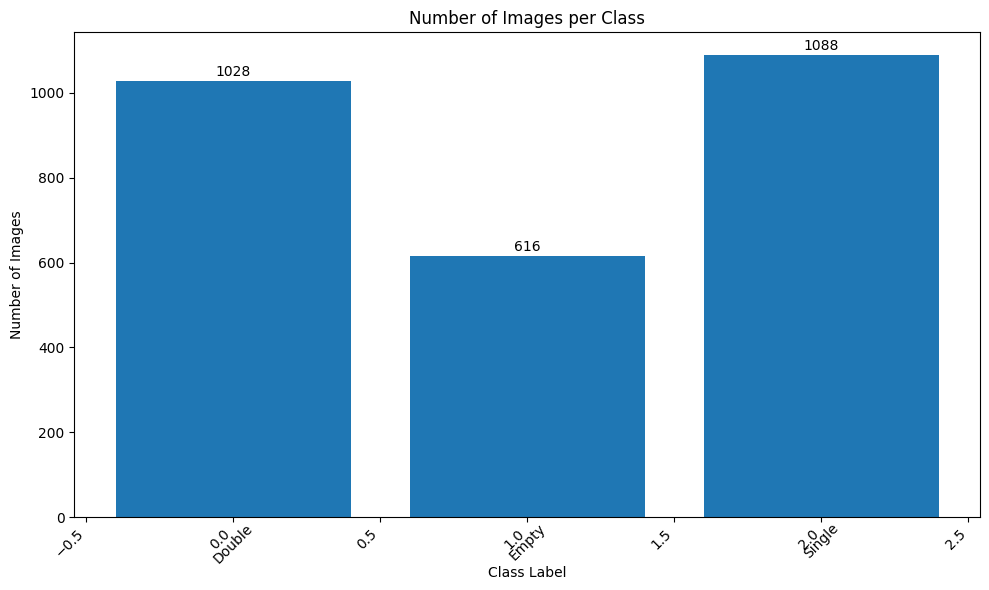

In [ ]:
# Extract the labels from the dataset:
labels = [sample[2] for sample in dataset_aav_ijepa.data]

# Count the occurrences of each label using Counter:
class_counts = Counter(labels)

# Get the class labels and their corresponding counts:
class_labels, counts = zip(*class_counts.items())

# Create the bar graph:
plt.figure(figsize=(10, 6))
plt.bar(class_labels, counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add text labels above the bars:
for i, count in enumerate(counts):
    plt.text(class_labels[i], count + 5,  # Adjust vertical position as needed
             str(count), ha='center', va='bottom')

# Add text labels for class names below the x-axis:
for i, label in enumerate(class_labels):
    plt.text(label, -10,  # Adjust vertical position as needed
             dataset.classes[label], ha='center', va='top', rotation=45)  # Assuming dataset has 'classes' attribute

plt.show()

In [ ]:
import torch
from torch.utils.data import Subset, random_split
from sklearn.model_selection import train_test_split

# Define the split ratios (e.g., 70% train, 15% validation, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Get the total number of samples in the dataset.
num_samples = len(dataset_aav_ijepa)

# 1. Split into train and (validation + test)
train_indices, val_test_indices = train_test_split(
    list(range(num_samples)),
    test_size=val_ratio + test_ratio,
    random_state=42  # Set random_state for reproducibility
)

# 2. Split (validation + test) into validation and test
val_indices, test_indices = train_test_split(
    val_test_indices,
    test_size=test_ratio / (val_ratio + test_ratio),
    random_state=42  # Set random_state for reproducibility
)

# Create Subset datasets for train, validation, and test
train_dataset_aav_ijepa = Subset(dataset_aav_ijepa, train_indices)
val_dataset_aav_ijepa = Subset(dataset_aav_ijepa, val_indices)
test_dataset_aav_ijepa = Subset(dataset_aav_ijepa, test_indices)

# Create DataLoaders for train, validation, and test
train_loader_aav_ijepa = torch.utils.data.DataLoader(train_dataset_aav_ijepa, batch_size=32, shuffle=True)
val_loader_aav_ijepa = torch.utils.data.DataLoader(val_dataset_aav_ijepa, batch_size=32, shuffle=False)
test_loader_aav_ijepa = torch.utils.data.DataLoader(test_dataset_aav_ijepa, batch_size=32, shuffle=False)

print(f"Training set size: {len(train_dataset_aav_ijepa)}")
print(f"Validation set size: {len(val_dataset_aav_ijepa)}")
print(f"Testing set size: {len(test_dataset_aav_ijepa)}")

Training set size: 1912
Validation set size: 410
Testing set size: 410


# VIT based i-jpea

In [ ]:
#def get_vit_encoder():
#    model = vit_b_16(pretrained=False)
#    model.heads = nn.Identity()  # remove classification head
#    return model

In [ ]:
#context_encoder = get_vit_encoder().cuda()
#target_encoder  = get_vit_encoder().cuda()
#target_encoder.load_state_dict(context_encoder.state_dict())

In [ ]:
'''class Predictor(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768, output_dim=768, num_targets=4):
        super().__init__()
        self.num_targets = num_targets
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_targets)
        )
    def forward(self, context_repr):
        pred = self.mlp(context_repr)
        # Reshape to [B, num_targets, output_dim]
        return pred.view(-1, self.num_targets, pred.size(-1) // self.num_targets)'''

# ResNet50

In [ ]:
from torchvision import models

'''def get_resnet_encoder():
    # Instantiate a ResNet50 and remove its classification head.
    model = models.resnet50(pretrained=False)
    model.fc = nn.Identity()  # Remove the fully-connected layer.
    return model'''

In [ ]:
# Update Predictor to use the new feature dimension (2048 for ResNet50)
'''class Predictor(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=2048, num_targets=4):
        super().__init__()
        self.num_targets = num_targets
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_targets)
        )
    def forward(self, context_repr):
        pred = self.mlp(context_repr)
        # Reshape output to [B, num_targets, output_dim]
        return pred.view(-1, self.num_targets, pred.size(-1) // self.num_targets)'''


In [ ]:
# Replace the previous get_vit_encoder() calls with get_resnet_encoder()
'''context_encoder = get_resnet_encoder().cuda()
target_encoder  = get_resnet_encoder().cuda()
# Initialize the target encoder with the context encoder's weights.
target_encoder.load_state_dict(context_encoder.state_dict())'''

In [ ]:
'''predictor = Predictor().cuda()
optimizer = optim.Adam(list(context_encoder.parameters()) + list(predictor.parameters()), lr=1e-1)
criterion = nn.MSELoss()'''

In [ ]:
'''@torch.no_grad()
def update_ema(model, model_ema, beta):
    for param, param_ema in zip(model.parameters(), model_ema.parameters()):
        param_ema.data.mul_(beta).add_(param.data, alpha=1 - beta)'''

# EfficientNet B2

In [ ]:
from torchvision.models import efficientnet_b2
def get_efficientnet_encoder():
    # Load EfficientNet B2 pretrained model and remove its classifier.
    model = efficientnet_b2(pretrained=True)
    model.classifier = nn.Identity()
    return model

In [ ]:
context_encoder = get_efficientnet_encoder().cuda()
target_encoder  = get_efficientnet_encoder().cuda()
target_encoder.load_state_dict(context_encoder.state_dict())

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 138MB/s]


<All keys matched successfully>

In [ ]:
# Update Predictor to use input_dim=1408 (EfficientNet B2's feature dimension)
class Predictor(nn.Module):
    def __init__(self, input_dim=1408, hidden_dim=1408, output_dim=1408, num_targets=4):
        super().__init__()
        self.num_targets = num_targets
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_targets)
        )
    def forward(self, context_repr):
        pred = self.mlp(context_repr)
        return pred.view(-1, self.num_targets, pred.size(-1) // self.num_targets)

predictor = Predictor(num_targets=7).cuda()

# Set up optimizer, criterion, and EMA update.
optimizer = optim.Adam(list(context_encoder.parameters()) + list(predictor.parameters()), lr=0.01)
criterion = nn.MSELoss()

In [ ]:
@torch.no_grad()
def update_ema(model, model_ema, beta):
    for param, param_ema in zip(model.parameters(), model_ema.parameters()):
        param_ema.data.mul_(beta).add_(param.data, alpha=1-beta)

# Self-Supervised i-JEPA Training with Validation Evaluation

In [ ]:
num_epochs = 500
ema_decay = 0.9
best_loss = float('inf')
total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    context_encoder.train()
    predictor.train()
    running_loss = 0.0

    # Enumerate over batches with a progress bar.
    for batch_idx, (context_block, target_blocks, _, _, _, _) in enumerate(tqdm(train_loader_aav_ijepa, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        context_block = context_block.cuda()            # [B, C, 224, 224]
        target_blocks = torch.stack(target_blocks, dim=1).cuda()
        #target_blocks = [tb.cuda() for tb in target_blocks]
        #target_blocks = target_blocks.cuda()              # [B, num_targets, C, 224, 224]

        # Forward pass through context encoder and predictor.
        context_repr = context_encoder(context_block)     # [B, 768]
        preds = predictor(context_repr)                   # [B, num_targets, 768]

        B, num_targets, C, Ht, Wt = target_blocks.shape
        target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
        with torch.no_grad():
            target_repr_flat = target_encoder(target_blocks_flat)
        target_repr = target_repr_flat.view(B, num_targets, -1)

        loss = criterion(preds, target_repr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(context_encoder, target_encoder, ema_decay)
        running_loss += loss.item() * context_block.size(0)

        # --- Visualization for first image of the current batch ---
        '''with torch.no_grad():
            # Get the first sample's context block and compute its feature vector.
            context_img = context_block[0].cpu()  # shape: [C, 224, 224]
            context_feat = context_encoder(context_block[0].unsqueeze(0)).cpu().squeeze(0)  # shape: [768]
            # Reshape feature vector to a 2D heatmap (24x32).
            context_heat = context_feat.view(24, 32).numpy()

            # For target, choose the first target block of the first sample.
            target_img = target_blocks[0][0].cpu()  # shape: [C, 224, 224]
            target_feat = target_encoder(target_blocks[0][0].unsqueeze(0).to(context_block.device)).cpu().squeeze(0)
            target_heat = target_feat.view(24, 32).numpy()

            # Plot the images and corresponding heatmaps.
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))

            # Display context block image.
            if context_img.shape[0] == 1:
                axs[0, 0].imshow(context_img.squeeze(), cmap='gray')
            else:
                axs[0, 0].imshow(context_img.permute(1, 2, 0))
            axs[0, 0].set_title("Context Block")
            axs[0, 0].axis("off")

            # Display context feature heatmap.
            im0 = axs[0, 1].imshow(context_heat, cmap="viridis")
            axs[0, 1].set_title("Context Feature Heatmap")
            axs[0, 1].axis("off")
            fig.colorbar(im0, ax=axs[0, 1])

            # Display target block image.
            if target_img.shape[0] == 1:
                axs[1, 0].imshow(target_img.squeeze(), cmap='gray')
            else:
                axs[1, 0].imshow(target_img.permute(1, 2, 0))
            axs[1, 0].set_title("Target Block")
            axs[1, 0].axis("off")

            # Display target feature heatmap.
            im1 = axs[1, 1].imshow(target_heat, cmap="viridis")
            axs[1, 1].set_title("Target Feature Heatmap")
            axs[1, 1].axis("off")
            fig.colorbar(im1, ax=axs[1, 1])

            # Save the visualization figure with epoch and batch number.
            viz_path = os.path.join(viz_dir, f"epoch{epoch+1}_batch{batch_idx+1}.png")
            plt.savefig(viz_path)
            plt.close(fig)'''

    epoch_loss = running_loss / len(train_dataset_aav_ijepa)
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.10f} - Epoch Time: {epoch_time:.2f}s")

    # Save checkpoint if current epoch loss is lower than previous best.
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = {
            'epoch': epoch+1,
            'context_encoder_state_dict': context_encoder.state_dict(),
            'target_encoder_state_dict': target_encoder.state_dict(),
            'predictor_state_dict': predictor.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }
        torch.save(checkpoint, os.path.join(base_dir,f"best_efficientnet_b2_model_raw_ema_{ema_decay}_lr_0.001_new_context_target.pth"))
        print(f"Checkpoint saved at epoch {epoch+1} with loss {epoch_loss:.4f}")


total_train_time = time.time() - total_start_time
print(f"Total Training Time: {total_train_time:.2f}s")

Epoch 1/500 - Train Loss: 0.5883350119 - Epoch Time: 13.27s
Checkpoint saved at epoch 1 with loss 0.5883


Epoch 2/500 - Train Loss: 0.0120822732 - Epoch Time: 13.34s
Checkpoint saved at epoch 2 with loss 0.0121


Epoch 3/500 - Train Loss: 0.0118398149 - Epoch Time: 13.36s
Checkpoint saved at epoch 3 with loss 0.0118


Epoch 4/500 - Train Loss: 0.0121287198 - Epoch Time: 13.17s


Epoch 5/500 - Train Loss: 0.0104142404 - Epoch Time: 13.41s
Checkpoint saved at epoch 5 with loss 0.0104


Epoch 6/500 - Train Loss: 0.0100255906 - Epoch Time: 13.39s
Checkpoint saved at epoch 6 with loss 0.0100


Epoch 7/500 - Train Loss: 0.0099769099 - Epoch Time: 13.29s
Checkpoint saved at epoch 7 with loss 0.0100


Epoch 8/500 - Train Loss: 0.0096138557 - Epoch Time: 13.28s
Checkpoint saved at epoch 8 with loss 0.0096


Epoch 9/500 - Train Loss: 0.0094756970 - Epoch Time: 13.34s
Checkpoint saved at epoch 9 with loss 0.0095


Epoch 10/500 - Train Loss: 0.0091686370 - Epoch Time: 13.16s
Checkpoint saved at epoch 10 with loss 0.0092


Epoch 11/500 - Train Loss: 0.0098000998 - Epoch Time: 13.28s


Epoch 12/500 - Train Loss: 0.0102206073 - Epoch Time: 13.20s


Epoch 13/500 - Train Loss: 0.0102747185 - Epoch Time: 13.33s


Epoch 14/500 - Train Loss: 0.0103961411 - Epoch Time: 13.34s


Epoch 15/500 - Train Loss: 0.0097002739 - Epoch Time: 13.40s


Epoch 16/500 - Train Loss: 0.0095543653 - Epoch Time: 13.26s


Epoch 17/500 - Train Loss: 0.0086957539 - Epoch Time: 13.39s
Checkpoint saved at epoch 17 with loss 0.0087


Epoch 18/500 - Train Loss: 0.0084089273 - Epoch Time: 13.20s
Checkpoint saved at epoch 18 with loss 0.0084


Epoch 19/500 - Train Loss: 0.0083205908 - Epoch Time: 13.17s
Checkpoint saved at epoch 19 with loss 0.0083


Epoch 20/500 - Train Loss: 0.0083324698 - Epoch Time: 13.20s


Epoch 21/500 - Train Loss: 0.0082594364 - Epoch Time: 13.20s
Checkpoint saved at epoch 21 with loss 0.0083


Epoch 22/500 - Train Loss: 0.0081954301 - Epoch Time: 13.16s
Checkpoint saved at epoch 22 with loss 0.0082


Epoch 23/500 - Train Loss: 0.0084016891 - Epoch Time: 13.13s


Epoch 24/500 - Train Loss: 0.0087156304 - Epoch Time: 13.48s


Epoch 25/500 - Train Loss: 0.0101292436 - Epoch Time: 13.31s


Epoch 26/500 - Train Loss: 0.0100825932 - Epoch Time: 13.35s


Epoch 27/500 - Train Loss: 0.0096233834 - Epoch Time: 13.44s


Epoch 28/500 - Train Loss: 0.0091337639 - Epoch Time: 13.31s


Epoch 29/500 - Train Loss: 0.0085395646 - Epoch Time: 13.35s


Epoch 30/500 - Train Loss: 0.0081153851 - Epoch Time: 13.36s
Checkpoint saved at epoch 30 with loss 0.0081


Epoch 31/500 - Train Loss: 0.0077953014 - Epoch Time: 13.25s
Checkpoint saved at epoch 31 with loss 0.0078


Epoch 32/500 - Train Loss: 0.0077973973 - Epoch Time: 13.19s


Epoch 33/500 - Train Loss: 0.0074306525 - Epoch Time: 13.44s
Checkpoint saved at epoch 33 with loss 0.0074


Epoch 34/500 - Train Loss: 0.0070386807 - Epoch Time: 13.40s
Checkpoint saved at epoch 34 with loss 0.0070


Epoch 35/500 - Train Loss: 0.0072801000 - Epoch Time: 13.26s


Epoch 36/500 - Train Loss: 0.0069402171 - Epoch Time: 13.25s
Checkpoint saved at epoch 36 with loss 0.0069


Epoch 37/500 - Train Loss: 0.0064433469 - Epoch Time: 13.24s
Checkpoint saved at epoch 37 with loss 0.0064


Epoch 38/500 - Train Loss: 0.0066020447 - Epoch Time: 13.24s


Epoch 39/500 - Train Loss: 0.0066187741 - Epoch Time: 13.24s


Epoch 40/500 - Train Loss: 0.0063497680 - Epoch Time: 13.26s
Checkpoint saved at epoch 40 with loss 0.0063


Epoch 41/500 - Train Loss: 0.0065667619 - Epoch Time: 13.18s


Epoch 42/500 - Train Loss: 0.0061755639 - Epoch Time: 13.47s
Checkpoint saved at epoch 42 with loss 0.0062


Epoch 43/500 - Train Loss: 0.0062447122 - Epoch Time: 13.20s


Epoch 44/500 - Train Loss: 0.0061180417 - Epoch Time: 13.23s
Checkpoint saved at epoch 44 with loss 0.0061


Epoch 45/500 - Train Loss: 0.0063462524 - Epoch Time: 13.23s


Epoch 46/500 - Train Loss: 0.0062480553 - Epoch Time: 13.31s


Epoch 47/500 - Train Loss: 0.0061358181 - Epoch Time: 13.39s


Epoch 48/500 - Train Loss: 0.0060865648 - Epoch Time: 13.23s
Checkpoint saved at epoch 48 with loss 0.0061


Epoch 49/500 - Train Loss: 0.0061430426 - Epoch Time: 13.38s


Epoch 50/500 - Train Loss: 0.0067676492 - Epoch Time: 13.31s


Epoch 51/500 - Train Loss: 0.0057253642 - Epoch Time: 13.48s
Checkpoint saved at epoch 51 with loss 0.0057


Epoch 52/500 - Train Loss: 0.0060467827 - Epoch Time: 13.20s


Epoch 53/500 - Train Loss: 0.0061666932 - Epoch Time: 13.17s


Epoch 54/500 - Train Loss: 0.0057904902 - Epoch Time: 13.28s


Epoch 55/500 - Train Loss: 0.0062359423 - Epoch Time: 13.29s


Epoch 56/500 - Train Loss: 0.0059942340 - Epoch Time: 13.30s


Epoch 57/500 - Train Loss: 0.0056748947 - Epoch Time: 13.33s
Checkpoint saved at epoch 57 with loss 0.0057


Epoch 58/500 - Train Loss: 0.0058224258 - Epoch Time: 13.20s


Epoch 59/500 - Train Loss: 0.0054445809 - Epoch Time: 13.23s
Checkpoint saved at epoch 59 with loss 0.0054


Epoch 60/500 - Train Loss: 0.0054399357 - Epoch Time: 13.20s
Checkpoint saved at epoch 60 with loss 0.0054


Epoch 61/500 - Train Loss: 0.0052653468 - Epoch Time: 13.27s
Checkpoint saved at epoch 61 with loss 0.0053


Epoch 62/500 - Train Loss: 0.0055184504 - Epoch Time: 13.17s


Epoch 63/500 - Train Loss: 0.0053636322 - Epoch Time: 13.16s


Epoch 64/500 - Train Loss: 0.0055265239 - Epoch Time: 13.32s


Epoch 65/500 - Train Loss: 0.0054063652 - Epoch Time: 13.36s


Epoch 66/500 - Train Loss: 0.0052204321 - Epoch Time: 13.34s
Checkpoint saved at epoch 66 with loss 0.0052


Epoch 67/500 - Train Loss: 0.0049866535 - Epoch Time: 13.24s
Checkpoint saved at epoch 67 with loss 0.0050


Epoch 68/500 - Train Loss: 0.0051704243 - Epoch Time: 13.23s


Epoch 69/500 - Train Loss: 0.0049774087 - Epoch Time: 13.29s
Checkpoint saved at epoch 69 with loss 0.0050


Epoch 70/500 - Train Loss: 0.0050595061 - Epoch Time: 13.33s


Epoch 71/500 - Train Loss: 0.0050952420 - Epoch Time: 13.46s


Epoch 72/500 - Train Loss: 0.0050438017 - Epoch Time: 13.25s


Epoch 73/500 - Train Loss: 0.0051020596 - Epoch Time: 13.21s


Epoch 74/500 - Train Loss: 0.0050018960 - Epoch Time: 13.33s


Epoch 75/500 - Train Loss: 0.0050723684 - Epoch Time: 13.27s


Epoch 76/500 - Train Loss: 0.0050491323 - Epoch Time: 13.27s


Epoch 77/500 - Train Loss: 0.0051628844 - Epoch Time: 13.38s


Epoch 78/500 - Train Loss: 0.0051582877 - Epoch Time: 13.25s


Epoch 79/500 - Train Loss: 0.0051894681 - Epoch Time: 13.29s


Epoch 80/500 - Train Loss: 0.0051671991 - Epoch Time: 13.31s


Epoch 81/500 - Train Loss: 0.0051935790 - Epoch Time: 13.38s


Epoch 82/500 - Train Loss: 0.0051254715 - Epoch Time: 13.32s


Epoch 83/500 - Train Loss: 0.0053299685 - Epoch Time: 13.37s


Epoch 84/500 - Train Loss: 0.0053032014 - Epoch Time: 13.33s


Epoch 85/500 - Train Loss: 0.0053191044 - Epoch Time: 13.21s


Epoch 86/500 - Train Loss: 0.0053245256 - Epoch Time: 13.32s


Epoch 87/500 - Train Loss: 0.0052738477 - Epoch Time: 13.31s


Epoch 88/500 - Train Loss: 0.0052599204 - Epoch Time: 13.32s


Epoch 89/500 - Train Loss: 0.0053493474 - Epoch Time: 13.26s


Epoch 90/500 - Train Loss: 0.0051348908 - Epoch Time: 13.26s


Epoch 91/500 - Train Loss: 0.0051606634 - Epoch Time: 13.33s


Epoch 92/500 - Train Loss: 0.0052434870 - Epoch Time: 13.27s


Epoch 93/500 - Train Loss: 0.0052776221 - Epoch Time: 13.31s


Epoch 94/500 - Train Loss: 0.0053885587 - Epoch Time: 13.38s


Epoch 95/500 - Train Loss: 0.0052745360 - Epoch Time: 13.34s


Epoch 96/500 - Train Loss: 0.0053567170 - Epoch Time: 13.22s


Epoch 97/500 - Train Loss: 0.0051364985 - Epoch Time: 13.24s


Epoch 98/500 - Train Loss: 0.0051887694 - Epoch Time: 13.34s


Epoch 99/500 - Train Loss: 0.0051362513 - Epoch Time: 13.29s


Epoch 100/500 - Train Loss: 0.0053633031 - Epoch Time: 13.38s


Epoch 101/500 - Train Loss: 0.0053029047 - Epoch Time: 13.38s


Epoch 102/500 - Train Loss: 0.0050599665 - Epoch Time: 13.27s


Epoch 103/500 - Train Loss: 0.0051390212 - Epoch Time: 13.25s


Epoch 104/500 - Train Loss: 0.0051534445 - Epoch Time: 13.34s


Epoch 105/500 - Train Loss: 0.0054251520 - Epoch Time: 13.30s


Epoch 106/500 - Train Loss: 0.0051673067 - Epoch Time: 13.27s


Epoch 107/500 - Train Loss: 0.0053524025 - Epoch Time: 13.24s


Epoch 108/500 - Train Loss: 0.0052837264 - Epoch Time: 13.24s


Epoch 109/500 - Train Loss: 0.0052446040 - Epoch Time: 13.30s


Epoch 110/500 - Train Loss: 0.0053824367 - Epoch Time: 13.27s


Epoch 111/500 - Train Loss: 0.0051483315 - Epoch Time: 13.31s


Epoch 112/500 - Train Loss: 0.0055245364 - Epoch Time: 13.24s


Epoch 113/500 - Train Loss: 0.0052319423 - Epoch Time: 13.28s


Epoch 114/500 - Train Loss: 0.0051334339 - Epoch Time: 13.34s


Epoch 115/500 - Train Loss: 0.0052796735 - Epoch Time: 13.35s


Epoch 116/500 - Train Loss: 0.0051606404 - Epoch Time: 13.26s


Epoch 117/500 - Train Loss: 0.0051983552 - Epoch Time: 13.33s


Epoch 118/500 - Train Loss: 0.0051747747 - Epoch Time: 13.27s


Epoch 119/500 - Train Loss: 0.0051427608 - Epoch Time: 13.26s


Epoch 120/500 - Train Loss: 0.0052942000 - Epoch Time: 13.33s


Epoch 121/500 - Train Loss: 0.0050983806 - Epoch Time: 13.24s


Epoch 122/500 - Train Loss: 0.0051082147 - Epoch Time: 13.22s


Epoch 123/500 - Train Loss: 0.0053895129 - Epoch Time: 13.28s


Epoch 124/500 - Train Loss: 0.0054607007 - Epoch Time: 13.26s


Epoch 125/500 - Train Loss: 0.0052645028 - Epoch Time: 13.33s


Epoch 126/500 - Train Loss: 0.0053445883 - Epoch Time: 13.30s


Epoch 127/500 - Train Loss: 0.0053450667 - Epoch Time: 13.44s


Epoch 128/500 - Train Loss: 0.0052019276 - Epoch Time: 13.32s


Epoch 129/500 - Train Loss: 0.0055664345 - Epoch Time: 13.30s


Epoch 130/500 - Train Loss: 0.0052077219 - Epoch Time: 13.30s


Epoch 131/500 - Train Loss: 0.0052287474 - Epoch Time: 13.36s


Epoch 132/500 - Train Loss: 0.0055367866 - Epoch Time: 13.26s


Epoch 133/500 - Train Loss: 0.0053092344 - Epoch Time: 13.44s


Epoch 134/500 - Train Loss: 0.0052467807 - Epoch Time: 13.31s


Epoch 135/500 - Train Loss: 0.0053881727 - Epoch Time: 13.37s


Epoch 136/500 - Train Loss: 0.0051994586 - Epoch Time: 13.35s


Epoch 137/500 - Train Loss: 0.0052954947 - Epoch Time: 13.29s


Epoch 138/500 - Train Loss: 0.0052189098 - Epoch Time: 13.24s


Epoch 139/500 - Train Loss: 0.0052442995 - Epoch Time: 13.30s


Epoch 140/500 - Train Loss: 0.0053347028 - Epoch Time: 13.31s


Epoch 141/500 - Train Loss: 0.0053935985 - Epoch Time: 13.34s


Epoch 142/500 - Train Loss: 0.0051521808 - Epoch Time: 13.35s


Epoch 143/500 - Train Loss: 0.0052503175 - Epoch Time: 13.29s


Epoch 144/500 - Train Loss: 0.0050247682 - Epoch Time: 13.30s


Epoch 145/500 - Train Loss: 0.0053164982 - Epoch Time: 13.28s


Epoch 146/500 - Train Loss: 0.0052189172 - Epoch Time: 13.26s


Epoch 147/500 - Train Loss: 0.0053792000 - Epoch Time: 13.33s


Epoch 148/500 - Train Loss: 0.0052586407 - Epoch Time: 13.30s


Epoch 149/500 - Train Loss: 0.0051626441 - Epoch Time: 13.26s


Epoch 150/500 - Train Loss: 0.0051318904 - Epoch Time: 13.36s


Epoch 151/500 - Train Loss: 0.0053400970 - Epoch Time: 13.34s


Epoch 152/500 - Train Loss: 0.0054640372 - Epoch Time: 13.37s


Epoch 153/500 - Train Loss: 0.0053932626 - Epoch Time: 13.31s


Epoch 154/500 - Train Loss: 0.0051745888 - Epoch Time: 13.24s


Epoch 155/500 - Train Loss: 0.0051516990 - Epoch Time: 13.27s


Epoch 156/500 - Train Loss: 0.0053218494 - Epoch Time: 13.37s


Epoch 157/500 - Train Loss: 0.0051731860 - Epoch Time: 13.41s


Epoch 158/500 - Train Loss: 0.0052365372 - Epoch Time: 13.34s


Epoch 159/500 - Train Loss: 0.0052516825 - Epoch Time: 13.33s


Epoch 160/500 - Train Loss: 0.0052536582 - Epoch Time: 13.39s


Epoch 161/500 - Train Loss: 0.0053421708 - Epoch Time: 13.44s


Epoch 162/500 - Train Loss: 0.0052252318 - Epoch Time: 13.35s


Epoch 163/500 - Train Loss: 0.0052650378 - Epoch Time: 13.26s


Epoch 164/500 - Train Loss: 0.0052954926 - Epoch Time: 13.45s


Epoch 165/500 - Train Loss: 0.0052022070 - Epoch Time: 13.34s


Epoch 166/500 - Train Loss: 0.0052027642 - Epoch Time: 13.31s


Epoch 167/500 - Train Loss: 0.0051712583 - Epoch Time: 13.31s


Epoch 168/500 - Train Loss: 0.0052818718 - Epoch Time: 13.36s


Epoch 169/500 - Train Loss: 0.0051892827 - Epoch Time: 13.34s


Epoch 170/500 - Train Loss: 0.0052996852 - Epoch Time: 13.25s


Epoch 171/500 - Train Loss: 0.0051433083 - Epoch Time: 13.29s


Epoch 172/500 - Train Loss: 0.0051979259 - Epoch Time: 13.22s


Epoch 173/500 - Train Loss: 0.0052818476 - Epoch Time: 13.28s


Epoch 174/500 - Train Loss: 0.0052541047 - Epoch Time: 13.38s


Epoch 175/500 - Train Loss: 0.0053237715 - Epoch Time: 13.35s


Epoch 176/500 - Train Loss: 0.0053344785 - Epoch Time: 13.25s


Epoch 177/500 - Train Loss: 0.0052882583 - Epoch Time: 13.28s


Epoch 178/500 - Train Loss: 0.0053260850 - Epoch Time: 13.25s


Epoch 179/500 - Train Loss: 0.0052736476 - Epoch Time: 13.36s


Epoch 180/500 - Train Loss: 0.0053384853 - Epoch Time: 13.32s


Epoch 181/500 - Train Loss: 0.0052388208 - Epoch Time: 13.33s


Epoch 182/500 - Train Loss: 0.0053449851 - Epoch Time: 13.29s


Epoch 183/500 - Train Loss: 0.0051743759 - Epoch Time: 13.33s


Epoch 184/500 - Train Loss: 0.0053589445 - Epoch Time: 13.39s


Epoch 185/500 - Train Loss: 0.0051934196 - Epoch Time: 13.43s


Epoch 186/500 - Train Loss: 0.0051781723 - Epoch Time: 13.39s


Epoch 187/500 - Train Loss: 0.0052298483 - Epoch Time: 13.46s


Epoch 188/500 - Train Loss: 0.0053906234 - Epoch Time: 13.30s


Epoch 189/500 - Train Loss: 0.0052906585 - Epoch Time: 13.33s


Epoch 190/500 - Train Loss: 0.0052658065 - Epoch Time: 13.24s


Epoch 191/500 - Train Loss: 0.0053191592 - Epoch Time: 13.36s


Epoch 192/500 - Train Loss: 0.0052041926 - Epoch Time: 13.39s


Epoch 193/500 - Train Loss: 0.0050913296 - Epoch Time: 13.30s


Epoch 194/500 - Train Loss: 0.0053391399 - Epoch Time: 13.32s


Epoch 195/500 - Train Loss: 0.0052725948 - Epoch Time: 13.34s


Epoch 196/500 - Train Loss: 0.0053567437 - Epoch Time: 13.26s


Epoch 197/500 - Train Loss: 0.0053371834 - Epoch Time: 13.30s


Epoch 198/500 - Train Loss: 0.0052244454 - Epoch Time: 13.36s


Epoch 199/500 - Train Loss: 0.0053316237 - Epoch Time: 13.25s


Epoch 200/500 - Train Loss: 0.0052381814 - Epoch Time: 13.32s


Epoch 201/500 - Train Loss: 0.0052316834 - Epoch Time: 13.31s


Epoch 202/500 - Train Loss: 0.0055381022 - Epoch Time: 13.36s


Epoch 203/500 - Train Loss: 0.0052012808 - Epoch Time: 13.25s


Epoch 204/500 - Train Loss: 0.0052599785 - Epoch Time: 13.22s


Epoch 205/500 - Train Loss: 0.0052543742 - Epoch Time: 13.31s


Epoch 206/500 - Train Loss: 0.0051517230 - Epoch Time: 13.31s


Epoch 207/500 - Train Loss: 0.0051955978 - Epoch Time: 13.42s


Epoch 208/500 - Train Loss: 0.0054975378 - Epoch Time: 13.40s


Epoch 209/500 - Train Loss: 0.0053600581 - Epoch Time: 13.36s


Epoch 210/500 - Train Loss: 0.0053750389 - Epoch Time: 13.46s


Epoch 211/500 - Train Loss: 0.0050997371 - Epoch Time: 13.24s


Epoch 212/500 - Train Loss: 0.0052606630 - Epoch Time: 13.36s


Epoch 213/500 - Train Loss: 0.0053608590 - Epoch Time: 13.35s


Epoch 214/500 - Train Loss: 0.0051655359 - Epoch Time: 13.30s


Epoch 215/500 - Train Loss: 0.0052704781 - Epoch Time: 13.26s


Epoch 216/500 - Train Loss: 0.0052906067 - Epoch Time: 13.27s


Epoch 217/500 - Train Loss: 0.0054404641 - Epoch Time: 13.38s


Epoch 218/500 - Train Loss: 0.0050404921 - Epoch Time: 13.29s


Epoch 219/500 - Train Loss: 0.0052365096 - Epoch Time: 13.26s


Epoch 220/500 - Train Loss: 0.0052188560 - Epoch Time: 13.34s


Epoch 221/500 - Train Loss: 0.0053191153 - Epoch Time: 13.32s


Epoch 222/500 - Train Loss: 0.0052738589 - Epoch Time: 13.30s


Epoch 223/500 - Train Loss: 0.0051196226 - Epoch Time: 13.37s


Epoch 224/500 - Train Loss: 0.0053138492 - Epoch Time: 13.28s


Epoch 225/500 - Train Loss: 0.0051918148 - Epoch Time: 13.28s


Epoch 226/500 - Train Loss: 0.0053491128 - Epoch Time: 13.34s


Epoch 227/500 - Train Loss: 0.0051617547 - Epoch Time: 13.31s


Epoch 228/500 - Train Loss: 0.0052401929 - Epoch Time: 13.30s


Epoch 229/500 - Train Loss: 0.0052322817 - Epoch Time: 13.33s


Epoch 230/500 - Train Loss: 0.0052734958 - Epoch Time: 13.36s


Epoch 231/500 - Train Loss: 0.0052720801 - Epoch Time: 13.41s


Epoch 232/500 - Train Loss: 0.0052845447 - Epoch Time: 13.36s


Epoch 233/500 - Train Loss: 0.0050990256 - Epoch Time: 13.25s


Epoch 234/500 - Train Loss: 0.0051861517 - Epoch Time: 13.30s


Epoch 235/500 - Train Loss: 0.0052137785 - Epoch Time: 13.50s


Epoch 236/500 - Train Loss: 0.0051800851 - Epoch Time: 13.29s


Epoch 237/500 - Train Loss: 0.0052464321 - Epoch Time: 13.46s


Epoch 238/500 - Train Loss: 0.0052932379 - Epoch Time: 13.39s


Epoch 239/500 - Train Loss: 0.0052968805 - Epoch Time: 13.31s


Epoch 240/500 - Train Loss: 0.0052501254 - Epoch Time: 13.31s


Epoch 241/500 - Train Loss: 0.0052225467 - Epoch Time: 13.37s


Epoch 242/500 - Train Loss: 0.0050991051 - Epoch Time: 13.32s


Epoch 243/500 - Train Loss: 0.0053897723 - Epoch Time: 13.28s


Epoch 244/500 - Train Loss: 0.0053392471 - Epoch Time: 13.34s


Epoch 245/500 - Train Loss: 0.0053384335 - Epoch Time: 13.35s


Epoch 246/500 - Train Loss: 0.0052585737 - Epoch Time: 13.30s


Epoch 247/500 - Train Loss: 0.0053543266 - Epoch Time: 13.29s


Epoch 248/500 - Train Loss: 0.0053930575 - Epoch Time: 13.30s


Epoch 249/500 - Train Loss: 0.0051503980 - Epoch Time: 13.38s


Epoch 250/500 - Train Loss: 0.0053074226 - Epoch Time: 13.36s


Epoch 251/500 - Train Loss: 0.0053892837 - Epoch Time: 13.38s


Epoch 252/500 - Train Loss: 0.0054447409 - Epoch Time: 13.25s


Epoch 253/500 - Train Loss: 0.0052389303 - Epoch Time: 13.29s


Epoch 254/500 - Train Loss: 0.0051327521 - Epoch Time: 13.41s


Epoch 255/500 - Train Loss: 0.0052476289 - Epoch Time: 13.41s


Epoch 256/500 - Train Loss: 0.0053131256 - Epoch Time: 13.30s


Epoch 257/500 - Train Loss: 0.0053977176 - Epoch Time: 13.28s


Epoch 258/500 - Train Loss: 0.0052392081 - Epoch Time: 13.26s


Epoch 259/500 - Train Loss: 0.0051996416 - Epoch Time: 13.23s


Epoch 260/500 - Train Loss: 0.0052307226 - Epoch Time: 13.26s


Epoch 261/500 - Train Loss: 0.0052130604 - Epoch Time: 13.32s


Epoch 262/500 - Train Loss: 0.0053121448 - Epoch Time: 13.31s


Epoch 263/500 - Train Loss: 0.0052748106 - Epoch Time: 13.37s


Epoch 264/500 - Train Loss: 0.0050827672 - Epoch Time: 13.39s


Epoch 265/500 - Train Loss: 0.0053432030 - Epoch Time: 13.36s


Epoch 266/500 - Train Loss: 0.0052531243 - Epoch Time: 13.30s


Epoch 267/500 - Train Loss: 0.0052211114 - Epoch Time: 13.41s


Epoch 268/500 - Train Loss: 0.0051467851 - Epoch Time: 13.30s


Epoch 269/500 - Train Loss: 0.0053510107 - Epoch Time: 13.28s


Epoch 270/500 - Train Loss: 0.0053069214 - Epoch Time: 13.23s


Epoch 271/500 - Train Loss: 0.0051532610 - Epoch Time: 13.28s


Epoch 272/500 - Train Loss: 0.0053709921 - Epoch Time: 13.28s


Epoch 273/500 - Train Loss: 0.0053442969 - Epoch Time: 13.26s


Epoch 274/500 - Train Loss: 0.0052849882 - Epoch Time: 13.37s


Epoch 275/500 - Train Loss: 0.0052244206 - Epoch Time: 13.30s


Epoch 276/500 - Train Loss: 0.0052374617 - Epoch Time: 13.46s


Epoch 277/500 - Train Loss: 0.0053724775 - Epoch Time: 13.49s


Epoch 278/500 - Train Loss: 0.0053021875 - Epoch Time: 13.34s


Epoch 279/500 - Train Loss: 0.0052154588 - Epoch Time: 13.33s


Epoch 280/500 - Train Loss: 0.0051962519 - Epoch Time: 13.32s


Epoch 281/500 - Train Loss: 0.0053000945 - Epoch Time: 13.34s


Epoch 282/500 - Train Loss: 0.0051164548 - Epoch Time: 13.37s


Epoch 283/500 - Train Loss: 0.0051601018 - Epoch Time: 13.41s


Epoch 284/500 - Train Loss: 0.0052858350 - Epoch Time: 13.29s


Epoch 285/500 - Train Loss: 0.0050919290 - Epoch Time: 13.31s


Epoch 286/500 - Train Loss: 0.0051165832 - Epoch Time: 13.40s


Epoch 287/500 - Train Loss: 0.0053704786 - Epoch Time: 13.42s


Epoch 288/500 - Train Loss: 0.0052848561 - Epoch Time: 13.26s


Epoch 289/500 - Train Loss: 0.0053756527 - Epoch Time: 13.24s


Epoch 290/500 - Train Loss: 0.0052215112 - Epoch Time: 13.41s


Epoch 291/500 - Train Loss: 0.0052040475 - Epoch Time: 13.25s


Epoch 292/500 - Train Loss: 0.0051512347 - Epoch Time: 13.34s


Epoch 293/500 - Train Loss: 0.0053180135 - Epoch Time: 13.37s


Epoch 294/500 - Train Loss: 0.0051914046 - Epoch Time: 13.35s


Epoch 295/500 - Train Loss: 0.0052455674 - Epoch Time: 13.31s


Epoch 296/500 - Train Loss: 0.0053324472 - Epoch Time: 13.33s


Epoch 297/500 - Train Loss: 0.0051163553 - Epoch Time: 13.38s


Epoch 298/500 - Train Loss: 0.0051831728 - Epoch Time: 13.42s


Epoch 299/500 - Train Loss: 0.0053745700 - Epoch Time: 13.37s


Epoch 300/500 - Train Loss: 0.0053029258 - Epoch Time: 13.37s


Epoch 301/500 - Train Loss: 0.0053687327 - Epoch Time: 13.33s


Epoch 302/500 - Train Loss: 0.0052752501 - Epoch Time: 13.34s


Epoch 303/500 - Train Loss: 0.0050833169 - Epoch Time: 13.31s


Epoch 304/500 - Train Loss: 0.0053398782 - Epoch Time: 13.41s


Epoch 305/500 - Train Loss: 0.0052964331 - Epoch Time: 13.36s


Epoch 306/500 - Train Loss: 0.0052751150 - Epoch Time: 13.36s


Epoch 307/500 - Train Loss: 0.0051448909 - Epoch Time: 13.22s


Epoch 308/500 - Train Loss: 0.0052295232 - Epoch Time: 13.28s


Epoch 309/500 - Train Loss: 0.0052506276 - Epoch Time: 13.66s


Epoch 310/500 - Train Loss: 0.0051877179 - Epoch Time: 13.27s


Epoch 311/500 - Train Loss: 0.0051207334 - Epoch Time: 13.35s


Epoch 312/500 - Train Loss: 0.0051684824 - Epoch Time: 13.39s


Epoch 313/500 - Train Loss: 0.0053798542 - Epoch Time: 13.36s


Epoch 314/500 - Train Loss: 0.0052265594 - Epoch Time: 13.26s


Epoch 315/500 - Train Loss: 0.0052668317 - Epoch Time: 13.25s


Epoch 316/500 - Train Loss: 0.0053468764 - Epoch Time: 13.32s


Epoch 317/500 - Train Loss: 0.0053619750 - Epoch Time: 13.30s


Epoch 318/500 - Train Loss: 0.0053359144 - Epoch Time: 13.38s


Epoch 319/500 - Train Loss: 0.0053226852 - Epoch Time: 13.34s


Epoch 320/500 - Train Loss: 0.0052102655 - Epoch Time: 13.30s


Epoch 321/500 - Train Loss: 0.0051701408 - Epoch Time: 13.47s


Epoch 322/500 - Train Loss: 0.0051791054 - Epoch Time: 13.37s


Epoch 323/500 - Train Loss: 0.0053245019 - Epoch Time: 13.37s


Epoch 324/500 - Train Loss: 0.0051395795 - Epoch Time: 13.27s


Epoch 325/500 - Train Loss: 0.0052355156 - Epoch Time: 13.25s


Epoch 326/500 - Train Loss: 0.0053182224 - Epoch Time: 13.35s


Epoch 327/500 - Train Loss: 0.0053143033 - Epoch Time: 13.29s


Epoch 328/500 - Train Loss: 0.0054786754 - Epoch Time: 13.33s


Epoch 329/500 - Train Loss: 0.0053418440 - Epoch Time: 13.34s


Epoch 330/500 - Train Loss: 0.0051557585 - Epoch Time: 13.28s


Epoch 331/500 - Train Loss: 0.0053555093 - Epoch Time: 13.26s


Epoch 332/500 - Train Loss: 0.0054017228 - Epoch Time: 13.31s


Epoch 333/500 - Train Loss: 0.0053969933 - Epoch Time: 13.41s


Epoch 334/500 - Train Loss: 0.0052493038 - Epoch Time: 13.29s


Epoch 335/500 - Train Loss: 0.0053325499 - Epoch Time: 13.29s


Epoch 336/500 - Train Loss: 0.0054894839 - Epoch Time: 13.24s


Epoch 337/500 - Train Loss: 0.0052819068 - Epoch Time: 13.25s


Epoch 338/500 - Train Loss: 0.0051562070 - Epoch Time: 13.32s


Epoch 339/500 - Train Loss: 0.0053006910 - Epoch Time: 13.27s


Epoch 340/500 - Train Loss: 0.0053150930 - Epoch Time: 13.30s


Epoch 341/500 - Train Loss: 0.0052263324 - Epoch Time: 13.38s


Epoch 342/500 - Train Loss: 0.0052777508 - Epoch Time: 13.37s


Epoch 343/500 - Train Loss: 0.0052759800 - Epoch Time: 13.46s


Epoch 344/500 - Train Loss: 0.0053024248 - Epoch Time: 13.47s


Epoch 345/500 - Train Loss: 0.0052932685 - Epoch Time: 13.44s


Epoch 346/500 - Train Loss: 0.0055200245 - Epoch Time: 13.32s


Epoch 347/500 - Train Loss: 0.0052767637 - Epoch Time: 13.35s


Epoch 348/500 - Train Loss: 0.0051525383 - Epoch Time: 13.36s


Epoch 349/500 - Train Loss: 0.0051900439 - Epoch Time: 13.29s


Epoch 350/500 - Train Loss: 0.0053363221 - Epoch Time: 13.36s


Epoch 351/500 - Train Loss: 0.0052978892 - Epoch Time: 13.33s


Epoch 352/500 - Train Loss: 0.0053315145 - Epoch Time: 13.32s


Epoch 353/500 - Train Loss: 0.0054483363 - Epoch Time: 13.28s


Epoch 354/500 - Train Loss: 0.0051875663 - Epoch Time: 13.33s


Epoch 355/500 - Train Loss: 0.0052663220 - Epoch Time: 13.27s


Epoch 356/500 - Train Loss: 0.0052653959 - Epoch Time: 13.42s


Epoch 357/500 - Train Loss: 0.0052277383 - Epoch Time: 13.27s


Epoch 358/500 - Train Loss: 0.0054723789 - Epoch Time: 13.32s


Epoch 359/500 - Train Loss: 0.0052633517 - Epoch Time: 13.35s


Epoch 360/500 - Train Loss: 0.0052852547 - Epoch Time: 13.35s


Epoch 361/500 - Train Loss: 0.0052402146 - Epoch Time: 13.32s


Epoch 362/500 - Train Loss: 0.0051192742 - Epoch Time: 13.37s


Epoch 363/500 - Train Loss: 0.0816942046 - Epoch Time: 13.43s


Epoch 364/500 - Train Loss: 2.3803866060 - Epoch Time: 13.33s


Epoch 365/500 - Train Loss: 0.0334754868 - Epoch Time: 13.37s


Epoch 366/500 - Train Loss: 0.0333682370 - Epoch Time: 13.36s


Epoch 367/500 - Train Loss: 0.0327517441 - Epoch Time: 13.46s


Epoch 368/500 - Train Loss: 0.0336318142 - Epoch Time: 13.26s


Epoch 369/500 - Train Loss: 0.0334622955 - Epoch Time: 13.29s


Epoch 370/500 - Train Loss: 0.0342832995 - Epoch Time: 13.41s


Epoch 371/500 - Train Loss: 0.0359339173 - Epoch Time: 13.28s


Epoch 372/500 - Train Loss: 0.0331100808 - Epoch Time: 13.30s


Epoch 373/500 - Train Loss: 0.0347315343 - Epoch Time: 13.27s


Epoch 374/500 - Train Loss: 0.0349562980 - Epoch Time: 13.34s


Epoch 375/500 - Train Loss: 0.0352146332 - Epoch Time: 13.40s


Epoch 376/500 - Train Loss: 0.0349095171 - Epoch Time: 13.31s


Epoch 377/500 - Train Loss: 0.0327742623 - Epoch Time: 13.36s


Epoch 378/500 - Train Loss: 0.0349021869 - Epoch Time: 13.38s


Epoch 379/500 - Train Loss: 0.0324530813 - Epoch Time: 13.35s


Epoch 380/500 - Train Loss: 0.0344368919 - Epoch Time: 13.29s


Epoch 381/500 - Train Loss: 19.7915809715 - Epoch Time: 13.32s


Epoch 382/500 - Train Loss: 0.1667141987 - Epoch Time: 13.27s


Epoch 383/500 - Train Loss: 0.0343502484 - Epoch Time: 13.34s


Epoch 384/500 - Train Loss: 0.0333611871 - Epoch Time: 13.32s


Epoch 385/500 - Train Loss: 0.0327874522 - Epoch Time: 13.32s


Epoch 386/500 - Train Loss: 0.0352739674 - Epoch Time: 13.39s


Epoch 387/500 - Train Loss: 0.0325687455 - Epoch Time: 13.38s


Epoch 388/500 - Train Loss: 0.0310398566 - Epoch Time: 13.37s


Epoch 389/500 - Train Loss: 0.0328514404 - Epoch Time: 13.50s


Epoch 390/500 - Train Loss: 0.0327066690 - Epoch Time: 13.45s


Epoch 391/500 - Train Loss: 0.0362843760 - Epoch Time: 13.37s


Epoch 392/500 - Train Loss: 0.0317186687 - Epoch Time: 13.32s


Epoch 393/500 - Train Loss: 0.0325405323 - Epoch Time: 13.44s


Epoch 394/500 - Train Loss: 0.0322965763 - Epoch Time: 13.25s


Epoch 395/500 - Train Loss: 0.0334409756 - Epoch Time: 13.32s


Epoch 396/500 - Train Loss: 0.0328971215 - Epoch Time: 13.39s


Epoch 397/500 - Train Loss: 0.0341267456 - Epoch Time: 13.39s


Epoch 398/500 - Train Loss: 0.0320834862 - Epoch Time: 13.32s


Epoch 399/500 - Train Loss: 0.0337249462 - Epoch Time: 13.34s


Epoch 400/500 - Train Loss: 0.0335587254 - Epoch Time: 13.29s


Epoch 401/500 - Train Loss: 0.0330257293 - Epoch Time: 13.40s


Epoch 402/500 - Train Loss: 0.0334267788 - Epoch Time: 13.38s


Epoch 403/500 - Train Loss: 0.0342032736 - Epoch Time: 13.38s


Epoch 404/500 - Train Loss: 0.0347259436 - Epoch Time: 13.46s


Epoch 405/500 - Train Loss: 0.0337881820 - Epoch Time: 13.40s


Epoch 406/500 - Train Loss: 0.0321762856 - Epoch Time: 13.38s


Epoch 407/500 - Train Loss: 0.0332950788 - Epoch Time: 13.38s


Epoch 408/500 - Train Loss: 0.0333592448 - Epoch Time: 13.39s


Epoch 409/500 - Train Loss: 0.0314240660 - Epoch Time: 13.35s


Epoch 410/500 - Train Loss: 0.0329050128 - Epoch Time: 13.44s


Epoch 411/500 - Train Loss: 0.0324802073 - Epoch Time: 13.41s


Epoch 412/500 - Train Loss: 0.0332798733 - Epoch Time: 13.38s


Epoch 413/500 - Train Loss: 0.0311212073 - Epoch Time: 13.27s


Epoch 414/500 - Train Loss: 0.0343331769 - Epoch Time: 13.34s


Epoch 415/500 - Train Loss: 0.0344176207 - Epoch Time: 13.32s


Epoch 416/500 - Train Loss: 0.0327768972 - Epoch Time: 13.38s


Epoch 417/500 - Train Loss: 0.0341584855 - Epoch Time: 13.37s


Epoch 418/500 - Train Loss: 0.0335598502 - Epoch Time: 13.34s


Epoch 419/500 - Train Loss: 0.0311173022 - Epoch Time: 13.35s


Epoch 420/500 - Train Loss: 0.0334521175 - Epoch Time: 13.29s


Epoch 421/500 - Train Loss: 0.0329351192 - Epoch Time: 13.32s


Epoch 422/500 - Train Loss: 0.0325578629 - Epoch Time: 13.27s


Epoch 423/500 - Train Loss: 0.0334695358 - Epoch Time: 13.22s


Epoch 424/500 - Train Loss: 0.0323676334 - Epoch Time: 13.31s


Epoch 425/500 - Train Loss: 0.0338140099 - Epoch Time: 13.31s


Epoch 426/500 - Train Loss: 0.0343866601 - Epoch Time: 13.30s


Epoch 427/500 - Train Loss: 0.0320810715 - Epoch Time: 13.28s


Epoch 428/500 - Train Loss: 0.0320935020 - Epoch Time: 13.36s


Epoch 429/500 - Train Loss: 0.0361180936 - Epoch Time: 13.28s


Epoch 430/500 - Train Loss: 0.0343821135 - Epoch Time: 13.27s


Epoch 431/500 - Train Loss: 0.0337863010 - Epoch Time: 13.37s


Epoch 432/500 - Train Loss: 0.0343857314 - Epoch Time: 13.38s


Epoch 433/500 - Train Loss: 0.0304819642 - Epoch Time: 13.43s


Epoch 434/500 - Train Loss: 0.0338768308 - Epoch Time: 13.40s


Epoch 435/500 - Train Loss: 0.0319901756 - Epoch Time: 13.44s


Epoch 436/500 - Train Loss: 0.0340926628 - Epoch Time: 13.34s


Epoch 437/500 - Train Loss: 0.0317381821 - Epoch Time: 13.28s


Epoch 438/500 - Train Loss: 0.0316072164 - Epoch Time: 13.36s


Epoch 439/500 - Train Loss: 0.0332972726 - Epoch Time: 13.24s


Epoch 440/500 - Train Loss: 0.0334090557 - Epoch Time: 13.31s


Epoch 441/500 - Train Loss: 0.0339827357 - Epoch Time: 13.29s


Epoch 442/500 - Train Loss: 0.0337519933 - Epoch Time: 13.30s


Epoch 443/500 - Train Loss: 0.0328087488 - Epoch Time: 13.40s


Epoch 444/500 - Train Loss: 0.0345224474 - Epoch Time: 13.38s


Epoch 445/500 - Train Loss: 0.0342335309 - Epoch Time: 13.38s


Epoch 446/500 - Train Loss: 0.0323223442 - Epoch Time: 13.32s


Epoch 447/500 - Train Loss: 0.0321786012 - Epoch Time: 13.33s


Epoch 448/500 - Train Loss: 0.0334642386 - Epoch Time: 13.29s


Epoch 449/500 - Train Loss: 0.0319508382 - Epoch Time: 13.31s


Epoch 450/500 - Train Loss: 0.0324431563 - Epoch Time: 13.32s


Epoch 451/500 - Train Loss: 0.0323156423 - Epoch Time: 13.30s


Epoch 452/500 - Train Loss: 0.0327455015 - Epoch Time: 13.27s


Epoch 453/500 - Train Loss: 0.0331385392 - Epoch Time: 13.27s


Epoch 454/500 - Train Loss: 0.0350742388 - Epoch Time: 13.31s


Epoch 455/500 - Train Loss: 0.0321458090 - Epoch Time: 13.39s


Epoch 456/500 - Train Loss: 0.0331163572 - Epoch Time: 13.35s


Epoch 457/500 - Train Loss: 0.0332732337 - Epoch Time: 13.44s


Epoch 458/500 - Train Loss: 0.0341927073 - Epoch Time: 13.32s


Epoch 459/500 - Train Loss: 0.0334159206 - Epoch Time: 13.39s


Epoch 460/500 - Train Loss: 0.0321419000 - Epoch Time: 13.21s


Epoch 461/500 - Train Loss: 0.0326115803 - Epoch Time: 13.35s


Epoch 462/500 - Train Loss: 0.0342700980 - Epoch Time: 13.25s


Epoch 463/500 - Train Loss: 0.0330904486 - Epoch Time: 13.26s


Epoch 464/500 - Train Loss: 0.0304378213 - Epoch Time: 13.37s


Epoch 465/500 - Train Loss: 0.0314923396 - Epoch Time: 13.36s


Epoch 466/500 - Train Loss: 0.0338853823 - Epoch Time: 13.38s


Epoch 467/500 - Train Loss: 0.0364507623 - Epoch Time: 13.23s


Epoch 468/500 - Train Loss: 0.0322149914 - Epoch Time: 13.33s


Epoch 469/500 - Train Loss: 0.0331810458 - Epoch Time: 13.32s


Epoch 470/500 - Train Loss: 0.0319264789 - Epoch Time: 13.43s


Epoch 471/500 - Train Loss: 0.0320781753 - Epoch Time: 13.37s


Epoch 472/500 - Train Loss: 0.0331775786 - Epoch Time: 13.39s


Epoch 473/500 - Train Loss: 0.0345649064 - Epoch Time: 13.28s


Epoch 474/500 - Train Loss: 0.0338300211 - Epoch Time: 13.29s


Epoch 475/500 - Train Loss: 0.0346008156 - Epoch Time: 13.31s


Epoch 476/500 - Train Loss: 0.0331853824 - Epoch Time: 13.44s


Epoch 477/500 - Train Loss: 0.0332888306 - Epoch Time: 13.29s


Epoch 478/500 - Train Loss: 0.0349484532 - Epoch Time: 13.45s


Epoch 479/500 - Train Loss: 0.0354645944 - Epoch Time: 13.42s


Epoch 480/500 - Train Loss: 0.0321501783 - Epoch Time: 13.42s


Epoch 481/500 - Train Loss: 0.0309913347 - Epoch Time: 13.32s


Epoch 482/500 - Train Loss: 0.0334760457 - Epoch Time: 13.35s


Epoch 483/500 - Train Loss: 0.0340516268 - Epoch Time: 13.29s


Epoch 484/500 - Train Loss: 0.0324957563 - Epoch Time: 13.33s


Epoch 485/500 - Train Loss: 0.0339885081 - Epoch Time: 13.30s


Epoch 486/500 - Train Loss: 0.0347778341 - Epoch Time: 13.41s


Epoch 487/500 - Train Loss: 0.0333263162 - Epoch Time: 13.34s


Epoch 488/500 - Train Loss: 0.0360619905 - Epoch Time: 13.40s


Epoch 489/500 - Train Loss: 0.0314136765 - Epoch Time: 13.35s


Epoch 490/500 - Train Loss: 0.0343998793 - Epoch Time: 13.39s


Epoch 491/500 - Train Loss: 0.0340104303 - Epoch Time: 13.28s


Epoch 492/500 - Train Loss: 0.0336622075 - Epoch Time: 13.28s


Epoch 493/500 - Train Loss: 0.0331780246 - Epoch Time: 13.30s


Epoch 494/500 - Train Loss: 0.0330940577 - Epoch Time: 13.39s


Epoch 495/500 - Train Loss: 0.0353850150 - Epoch Time: 13.41s


Epoch 496/500 - Train Loss: 0.0322342644 - Epoch Time: 13.44s


Epoch 497/500 - Train Loss: 0.0337055224 - Epoch Time: 13.29s


Epoch 498/500 - Train Loss: 0.0323751884 - Epoch Time: 13.27s


Epoch 499/500 - Train Loss: 0.0316148853 - Epoch Time: 13.34s


Epoch 500/500 - Train Loss: 0.0327819666 - Epoch Time: 13.42s
Total Training Time: 6713.65s


## Grid Search ema decay and learning rate

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# Define candidate values for EMA decay and learning rate.
ema_decay_candidates = [0.1, 0.3, 0.5, 0.7, 0.95, 0.99]
lr_candidates = [1e-1, 1e-2, 1e-3, 1e-4]

num_epochs_grid = 5  # Maximum epochs for each grid search candidate.
patience = 1         # Early stopping patience.

grid_results = {}     # Dictionary to store best validation loss for each candidate.
grid_training_curves = {}  # (Optional) store training losses per candidate.
grid_validation_curves = {}  # (Optional) store validation losses per candidate.

# Dictionary to store the temporary checkpoint filename for each candidate.
candidate_ckpt_files = {}
best_val_loss_candidate = float('inf')
for ema_candidate in ema_decay_candidates:
    for lr_candidate in lr_candidates:
        print(f"\nTraining with ema_decay = {ema_candidate} and learning rate = {lr_candidate}")
        # --- Reinitialize the models for each candidate combination ---
        context_encoder = get_efficientnet_encoder().cuda()
        target_encoder  = get_efficientnet_encoder().cuda()
        target_encoder.load_state_dict(context_encoder.state_dict())
        predictor = Predictor(num_targets=7).cuda()  # Predictor expects 2048 features.

        optimizer = optim.Adam(list(context_encoder.parameters()) + list(predictor.parameters()), lr=lr_candidate)

        # Define temporary checkpoint filename.
        tmp_ckpt_filename = os.path.join(base_dir, f"tmp_efficientnet_b2_model_raw_ema_{ema_candidate}_lr_{lr_candidate}_new_context_target.pth")

        candidate_ckpt_files[(ema_candidate, lr_candidate)] = tmp_ckpt_filename

        # Initialize tracking variables.

        patience_counter = 0
        start_epoch = 0
        candidate_train_losses = []
        candidate_val_losses = []

        # --- Resume training if temporary checkpoint exists ---
        if os.path.exists(tmp_ckpt_filename):
            checkpoint = torch.load(tmp_ckpt_filename)
            start_epoch = checkpoint['epoch']
            best_val_loss_candidate = checkpoint['val_loss']
            context_encoder.load_state_dict(checkpoint['context_encoder_state_dict'])
            target_encoder.load_state_dict(checkpoint['target_encoder_state_dict'])
            predictor.load_state_dict(checkpoint['predictor_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Resuming from checkpoint at epoch {start_epoch} for (ema_decay={ema_candidate}, lr={lr_candidate})")

        # Training loop for the current candidate.
        for epoch in range(start_epoch, num_epochs_grid):
            epoch_start_time = time.time()
            context_encoder.train()
            predictor.train()
            running_loss = 0.0

            # --- Training Loop ---
            for batch_idx, (context_block, target_blocks, _, _, _, _) in enumerate(
                    tqdm(train_loader_aav_ijepa, desc=f"Candidate Epoch {epoch+1}/{num_epochs_grid}", leave=False)):
                context_block = context_block.cuda()            # [B, C, 224, 224]
                target_blocks = torch.stack(target_blocks, dim=1).cuda()            # [B, num_targets, C, 224, 224]

                # Forward pass.
                context_repr = context_encoder(context_block)     # [B, 2048]
                preds = predictor(context_repr)                   # [B, num_targets, 2048]

                B, num_targets, C, Ht, Wt = target_blocks.shape
                target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
                with torch.no_grad():
                    target_repr_flat = target_encoder(target_blocks_flat)
                target_repr = target_repr_flat.view(B, num_targets, -1)  # [B, num_targets, 2048]

                loss = criterion(preds, target_repr)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                update_ema(context_encoder, target_encoder, ema_candidate)
                running_loss += loss.item() * context_block.size(0)

            epoch_loss = running_loss / len(train_dataset_aav_ijepa)
            candidate_train_losses.append(epoch_loss)
            train_time = time.time() - epoch_start_time

            # --- Validation Evaluation ---
            context_encoder.eval()
            predictor.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for context_block, target_blocks, _, _, _, _ in val_loader_aav_ijepa:
                    context_block = context_block.cuda()
                    #target_blocks = target_blocks.cuda()
                    target_blocks = torch.stack(target_blocks, dim=1).cuda()
                    context_repr = context_encoder(context_block)
                    preds = predictor(context_repr)

                    B, num_targets, C, Ht, Wt = target_blocks.shape
                    target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
                    target_repr_flat = target_encoder(target_blocks_flat)
                    target_repr = target_repr_flat.view(B, num_targets, -1)

                    loss_val = criterion(preds, target_repr)
                    running_val_loss += loss_val.item() * context_block.size(0)
            val_loss = running_val_loss / len(val_dataset_aav_ijepa)
            candidate_val_losses.append(val_loss)
            print(f"Epoch {epoch+1}/{num_epochs_grid} - Train Loss: {epoch_loss:.6f} - Val Loss: {val_loss:.6f} - Time: {train_time:.2f}s")

            # --- Check for Improvement and Save Temporary Checkpoint ---
            if val_loss < best_val_loss_candidate:
                best_val_loss_candidate = val_loss
                patience_counter = 0
                checkpoint = {
                    'epoch': epoch+1,
                    'context_encoder_state_dict': context_encoder.state_dict(),
                    'target_encoder_state_dict': target_encoder.state_dict(),
                    'predictor_state_dict': predictor.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'ema_decay': ema_candidate,
                    'lr': lr_candidate
                }
                torch.save(checkpoint, tmp_ckpt_filename)
                print(f"Temporary checkpoint saved at epoch {epoch+1} with Val Loss: {val_loss:.6f} for (ema_decay={ema_candidate}, lr={lr_candidate})")
            else:
                patience_counter += 1
                print(f"No improvement in validation loss for {patience_counter} epoch(s).")
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs for (ema_decay={ema_candidate}, lr={lr_candidate}).")
                    break

        grid_results[(ema_candidate, lr_candidate)] = best_val_loss_candidate
        grid_training_curves[(ema_candidate, lr_candidate)] = candidate_train_losses
        grid_validation_curves[(ema_candidate, lr_candidate)] = candidate_val_losses
        print(f"Combination (ema_decay={ema_candidate}, lr={lr_candidate}) - Best Val Loss: {best_val_loss_candidate:.6f}")

# Display grid search results.
print("\nGrid Search Results (EMA Decay, LR) -> Best Val Loss:")
for params, loss_val in grid_results.items():
    print(f"  {params} -> {loss_val:.6f}")

# Find the best hyperparameters based on the validation loss.
best_params = min(grid_results, key=grid_results.get)
best_loss = grid_results[best_params]
print(f"\nBest parameters: EMA decay = {best_params[0]}, Learning Rate = {best_params[1]} with Val Loss: {best_loss:.6f}")

# Load the best candidate's checkpoint from its temporary file and save as best checkpoint.
best_tmp_ckpt_filename = candidate_ckpt_files[best_params]
if os.path.exists(best_tmp_ckpt_filename):
    best_checkpoint = torch.load(best_tmp_ckpt_filename)
    best_ckpt_filename = os.path.join(base_dir, f"best_efficientnet_b2_model_raw_ema_{best_params[0]}_lr_{best_params[1]}_new_context_target.pth")
    torch.save(best_checkpoint, best_ckpt_filename)
    print(f"Best checkpoint saved as {best_ckpt_filename}")
else:
    print("No checkpoint file found for the best candidate.")



Training with ema_decay = 0.1 and learning rate = 0.1


Epoch 1/5 - Train Loss: 25366.128705 - Val Loss: 0.266372 - Time: 13.15s
Temporary checkpoint saved at epoch 1 with Val Loss: 0.266372 for (ema_decay=0.1, lr=0.1)


Epoch 2/5 - Train Loss: 0.256324 - Val Loss: 0.240690 - Time: 13.22s
Temporary checkpoint saved at epoch 2 with Val Loss: 0.240690 for (ema_decay=0.1, lr=0.1)


Epoch 3/5 - Train Loss: 0.231581 - Val Loss: 0.217244 - Time: 13.21s
Temporary checkpoint saved at epoch 3 with Val Loss: 0.217244 for (ema_decay=0.1, lr=0.1)


Epoch 4/5 - Train Loss: 0.215748 - Val Loss: 0.196693 - Time: 13.26s
Temporary checkpoint saved at epoch 4 with Val Loss: 0.196693 for (ema_decay=0.1, lr=0.1)


Epoch 5/5 - Train Loss: 0.189924 - Val Loss: 0.174788 - Time: 13.12s
Temporary checkpoint saved at epoch 5 with Val Loss: 0.174788 for (ema_decay=0.1, lr=0.1)
Combination (ema_decay=0.1, lr=0.1) - Best Val Loss: 0.174788

Training with ema_decay = 0.1 and learning rate = 0.01


Epoch 1/5 - Train Loss: 1.475811 - Val Loss: 0.028385 - Time: 13.29s
Temporary checkpoint saved at epoch 1 with Val Loss: 0.028385 for (ema_decay=0.1, lr=0.01)


Epoch 2/5 - Train Loss: 0.019293 - Val Loss: 0.019277 - Time: 13.42s
Temporary checkpoint saved at epoch 2 with Val Loss: 0.019277 for (ema_decay=0.1, lr=0.01)


Epoch 3/5 - Train Loss: 0.020456 - Val Loss: 0.020719 - Time: 13.11s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 3 epochs for (ema_decay=0.1, lr=0.01).
Combination (ema_decay=0.1, lr=0.01) - Best Val Loss: 0.019277

Training with ema_decay = 0.1 and learning rate = 0.001


Epoch 1/5 - Train Loss: 0.056363 - Val Loss: 0.038105 - Time: 13.26s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.1, lr=0.001).
Combination (ema_decay=0.1, lr=0.001) - Best Val Loss: 0.019277

Training with ema_decay = 0.1 and learning rate = 0.0001


Epoch 1/5 - Train Loss: 0.075148 - Val Loss: 0.054083 - Time: 13.22s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.1, lr=0.0001).
Combination (ema_decay=0.1, lr=0.0001) - Best Val Loss: 0.019277

Training with ema_decay = 0.3 and learning rate = 0.1


Epoch 1/5 - Train Loss: 73717.619379 - Val Loss: 34954.058422 - Time: 13.15s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.3, lr=0.1).
Combination (ema_decay=0.3, lr=0.1) - Best Val Loss: 0.019277

Training with ema_decay = 0.3 and learning rate = 0.01


Epoch 1/5 - Train Loss: 1.787204 - Val Loss: 0.025125 - Time: 13.16s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.3, lr=0.01).
Combination (ema_decay=0.3, lr=0.01) - Best Val Loss: 0.019277

Training with ema_decay = 0.3 and learning rate = 0.001


Epoch 1/5 - Train Loss: 0.044135 - Val Loss: 0.026763 - Time: 13.16s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.3, lr=0.001).
Combination (ema_decay=0.3, lr=0.001) - Best Val Loss: 0.019277

Training with ema_decay = 0.3 and learning rate = 0.0001


Epoch 1/5 - Train Loss: 0.069552 - Val Loss: 0.044754 - Time: 13.12s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.3, lr=0.0001).
Combination (ema_decay=0.3, lr=0.0001) - Best Val Loss: 0.019277

Training with ema_decay = 0.5 and learning rate = 0.1


Epoch 1/5 - Train Loss: 79098.998593 - Val Loss: 2862.837745 - Time: 13.14s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.5, lr=0.1).
Combination (ema_decay=0.5, lr=0.1) - Best Val Loss: 0.019277

Training with ema_decay = 0.5 and learning rate = 0.01


Epoch 1/5 - Train Loss: 1.006921 - Val Loss: 0.031463 - Time: 13.13s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.5, lr=0.01).
Combination (ema_decay=0.5, lr=0.01) - Best Val Loss: 0.019277

Training with ema_decay = 0.5 and learning rate = 0.001


Epoch 1/5 - Train Loss: 0.054372 - Val Loss: 0.033727 - Time: 13.09s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.5, lr=0.001).
Combination (ema_decay=0.5, lr=0.001) - Best Val Loss: 0.019277

Training with ema_decay = 0.5 and learning rate = 0.0001


Epoch 1/5 - Train Loss: 0.071673 - Val Loss: 0.050007 - Time: 13.08s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.5, lr=0.0001).
Combination (ema_decay=0.5, lr=0.0001) - Best Val Loss: 0.019277

Training with ema_decay = 0.7 and learning rate = 0.1


Epoch 1/5 - Train Loss: 44030.183231 - Val Loss: 163.642457 - Time: 13.17s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.7, lr=0.1).
Combination (ema_decay=0.7, lr=0.1) - Best Val Loss: 0.019277

Training with ema_decay = 0.7 and learning rate = 0.01


Epoch 1/5 - Train Loss: 1.994799 - Val Loss: 0.038682 - Time: 13.20s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.7, lr=0.01).
Combination (ema_decay=0.7, lr=0.01) - Best Val Loss: 0.019277

Training with ema_decay = 0.7 and learning rate = 0.001


Epoch 1/5 - Train Loss: 0.029049 - Val Loss: 0.012521 - Time: 13.31s
Temporary checkpoint saved at epoch 1 with Val Loss: 0.012521 for (ema_decay=0.7, lr=0.001)


Epoch 2/5 - Train Loss: 0.010857 - Val Loss: 0.009783 - Time: 13.33s
Temporary checkpoint saved at epoch 2 with Val Loss: 0.009783 for (ema_decay=0.7, lr=0.001)


Epoch 3/5 - Train Loss: 0.008719 - Val Loss: 0.007921 - Time: 13.27s
Temporary checkpoint saved at epoch 3 with Val Loss: 0.007921 for (ema_decay=0.7, lr=0.001)


Epoch 4/5 - Train Loss: 0.007906 - Val Loss: 0.007980 - Time: 13.33s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 4 epochs for (ema_decay=0.7, lr=0.001).
Combination (ema_decay=0.7, lr=0.001) - Best Val Loss: 0.007921

Training with ema_decay = 0.7 and learning rate = 0.0001


Epoch 1/5 - Train Loss: 0.078592 - Val Loss: 0.056181 - Time: 13.29s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.7, lr=0.0001).
Combination (ema_decay=0.7, lr=0.0001) - Best Val Loss: 0.007921

Training with ema_decay = 0.95 and learning rate = 0.1


Epoch 1/5 - Train Loss: 39462.238062 - Val Loss: 19.575971 - Time: 13.15s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.95, lr=0.1).
Combination (ema_decay=0.95, lr=0.1) - Best Val Loss: 0.007921

Training with ema_decay = 0.95 and learning rate = 0.01


Epoch 1/5 - Train Loss: 1.013126 - Val Loss: 0.023054 - Time: 13.14s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.95, lr=0.01).
Combination (ema_decay=0.95, lr=0.01) - Best Val Loss: 0.007921

Training with ema_decay = 0.95 and learning rate = 0.001


Epoch 1/5 - Train Loss: 0.055278 - Val Loss: 0.031146 - Time: 13.28s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.95, lr=0.001).
Combination (ema_decay=0.95, lr=0.001) - Best Val Loss: 0.007921

Training with ema_decay = 0.95 and learning rate = 0.0001


Epoch 1/5 - Train Loss: 0.089358 - Val Loss: 0.070078 - Time: 13.32s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.95, lr=0.0001).
Combination (ema_decay=0.95, lr=0.0001) - Best Val Loss: 0.007921

Training with ema_decay = 0.99 and learning rate = 0.1


Epoch 1/5 - Train Loss: 120650.080158 - Val Loss: 1831053915.629268 - Time: 13.28s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.99, lr=0.1).
Combination (ema_decay=0.99, lr=0.1) - Best Val Loss: 0.007921

Training with ema_decay = 0.99 and learning rate = 0.01


Epoch 1/5 - Train Loss: 0.847916 - Val Loss: 0.044644 - Time: 13.32s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.99, lr=0.01).
Combination (ema_decay=0.99, lr=0.01) - Best Val Loss: 0.007921

Training with ema_decay = 0.99 and learning rate = 0.001


Epoch 1/5 - Train Loss: 0.079330 - Val Loss: 0.053435 - Time: 13.25s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.99, lr=0.001).
Combination (ema_decay=0.99, lr=0.001) - Best Val Loss: 0.007921

Training with ema_decay = 0.99 and learning rate = 0.0001


Epoch 1/5 - Train Loss: 0.097926 - Val Loss: 0.087981 - Time: 13.26s
No improvement in validation loss for 1 epoch(s).
Early stopping triggered after 1 epochs for (ema_decay=0.99, lr=0.0001).
Combination (ema_decay=0.99, lr=0.0001) - Best Val Loss: 0.007921

Grid Search Results (EMA Decay, LR) -> Best Val Loss:
  (0.1, 0.1) -> 0.174788
  (0.1, 0.01) -> 0.019277
  (0.1, 0.001) -> 0.019277
  (0.1, 0.0001) -> 0.019277
  (0.3, 0.1) -> 0.019277
  (0.3, 0.01) -> 0.019277
  (0.3, 0.001) -> 0.019277
  (0.3, 0.0001) -> 0.019277
  (0.5, 0.1) -> 0.019277
  (0.5, 0.01) -> 0.019277
  (0.5, 0.001) -> 0.019277
  (0.5, 0.0001) -> 0.019277
  (0.7, 0.1) -> 0.019277
  (0.7, 0.01) -> 0.019277
  (0.7, 0.001) -> 0.007921
  (0.7, 0.0001) -> 0.007921
  (0.95, 0.1) -> 0.007921
  (0.95, 0.01) -> 0.007921
  (0.95, 0.001) -> 0.007921
  (0.95, 0.0001) -> 0.007921
  (0.99, 0.1) -> 0.007921
  (0.99, 0.01) -> 0.007921
  (0.99, 0.001) -> 0.007921
  (0.99, 0.0001) -> 0.007921

Best parameters: EMA decay = 0.7, Learning

In [ ]:
num_epochs = 10
ema_decay = 0.1
best_loss = float('inf')
total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    context_encoder.train()
    predictor.train()
    running_loss = 0.0

    # Enumerate over batches with a progress bar.
    for batch_idx, (context_block, target_blocks, _, _) in enumerate(tqdm(train_loader_aav_ijepa, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        context_block = context_block.cuda()            # [B, C, 224, 224]
        target_blocks = target_blocks.cuda()              # [B, num_targets, C, 224, 224]

        # Forward pass through context encoder and predictor.
        context_repr = context_encoder(context_block)     # [B, 768]
        preds = predictor(context_repr)                   # [B, num_targets, 768]

        B, num_targets, C, Ht, Wt = target_blocks.shape
        target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
        with torch.no_grad():
            target_repr_flat = target_encoder(target_blocks_flat)
        target_repr = target_repr_flat.view(B, num_targets, -1)

        loss = criterion(preds, target_repr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(context_encoder, target_encoder, ema_decay)
        running_loss += loss.item() * context_block.size(0)

        # --- Visualization for first image of the current batch ---
        '''with torch.no_grad():
            # Get the first sample's context block and compute its feature vector.
            context_img = context_block[0].cpu()  # shape: [C, 224, 224]
            context_feat = context_encoder(context_block[0].unsqueeze(0)).cpu().squeeze(0)  # shape: [768]
            # Reshape feature vector to a 2D heatmap (24x32).
            context_heat = context_feat.view(24, 32).numpy()

            # For target, choose the first target block of the first sample.
            target_img = target_blocks[0][0].cpu()  # shape: [C, 224, 224]
            target_feat = target_encoder(target_blocks[0][0].unsqueeze(0).to(context_block.device)).cpu().squeeze(0)
            target_heat = target_feat.view(24, 32).numpy()

            # Plot the images and corresponding heatmaps.
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))

            # Display context block image.
            if context_img.shape[0] == 1:
                axs[0, 0].imshow(context_img.squeeze(), cmap='gray')
            else:
                axs[0, 0].imshow(context_img.permute(1, 2, 0))
            axs[0, 0].set_title("Context Block")
            axs[0, 0].axis("off")

            # Display context feature heatmap.
            im0 = axs[0, 1].imshow(context_heat, cmap="viridis")
            axs[0, 1].set_title("Context Feature Heatmap")
            axs[0, 1].axis("off")
            fig.colorbar(im0, ax=axs[0, 1])

            # Display target block image.
            if target_img.shape[0] == 1:
                axs[1, 0].imshow(target_img.squeeze(), cmap='gray')
            else:
                axs[1, 0].imshow(target_img.permute(1, 2, 0))
            axs[1, 0].set_title("Target Block")
            axs[1, 0].axis("off")

            # Display target feature heatmap.
            im1 = axs[1, 1].imshow(target_heat, cmap="viridis")
            axs[1, 1].set_title("Target Feature Heatmap")
            axs[1, 1].axis("off")
            fig.colorbar(im1, ax=axs[1, 1])

            # Save the visualization figure with epoch and batch number.
            viz_path = os.path.join(viz_dir, f"epoch{epoch+1}_batch{batch_idx+1}.png")
            plt.savefig(viz_path)
            plt.close(fig)'''

    epoch_loss = running_loss / len(train_dataset_aav_ijepa)
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.10f} - Epoch Time: {epoch_time:.2f}s")

    # Save checkpoint if current epoch loss is lower than previous best.
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = {
            'epoch': epoch+1,
            'context_encoder_state_dict': context_encoder.state_dict(),
            'target_encoder_state_dict': target_encoder.state_dict(),
            'predictor_state_dict': predictor.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }
        torch.save(checkpoint, os.path.join(base_dir,"ijepa_checkpoint_best.pth"))
        print(f"Checkpoint saved at epoch {epoch+1} with loss {epoch_loss:.4f}")


total_train_time = time.time() - total_start_time
print(f"Total Training Time: {total_train_time:.2f}s")

# Loading pretrained model

In [ ]:
import os
import torch

# Define the checkpoint filename (adjust parameters as needed).
#ckpt_filename = os.path.join(base_dir, "best_resnet50_model_ema_0.95_lr_0.001.pth")
ckpt_filename = best_ckpt_filename
print(f"Checkpoint loaded for evaluation: {best_tmp_ckpt_filename}")
# Load the checkpoint.
checkpoint = torch.load(ckpt_filename, map_location=device)

# Load the state dictionaries into your model instances.
context_encoder.load_state_dict(checkpoint['context_encoder_state_dict'])
target_encoder.load_state_dict(checkpoint['target_encoder_state_dict'])
predictor.load_state_dict(checkpoint['predictor_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally, retrieve other metadata.
start_epoch = checkpoint['epoch']
val_loss = checkpoint['val_loss']

print(f"Checkpoint loaded from epoch {start_epoch} with validation loss {val_loss:.6f}")


# Visualization of Output from I-Jepa

In [ ]:
# Modified extraction function returning coordinates.
def extract_blocks_with_coords(image, context_scale=0.85, target_scale=0.2, num_targets=4, max_overlap=0.5):
    # image: tensor of shape [C, H, W]
    _, H, W = image.shape
    context_size = int(context_scale * H)
    top = (H - context_size) // 2
    left = (W - context_size) // 2
    # Extract context block.
    context_block = image[:, top:top+context_size, left:left+context_size]
    context_block = torch.nn.functional.interpolate(
        context_block.unsqueeze(0),
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    ).squeeze(0)
    # Coordinates for context: (left, top, width, height)
    context_coords = (left, top, context_size, context_size)

    # Extract target blocks and record their coordinates.
    target_blocks = []
    target_coords = []
    for _ in range(num_targets):
        target_size = int(target_scale * H)
        top_t = random.randint(0, H - target_size)
        left_t = random.randint(0, W - target_size)
        target_coords.append((left_t, top_t, target_size, target_size))
        target_block = image[:, top_t:top_t+target_size, left_t:left_t+target_size]
        target_block = torch.nn.functional.interpolate(
            target_block.unsqueeze(0),
            size=(224, 224),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)
        target_blocks.append(target_block)
    target_blocks = torch.stack(target_blocks)
    return context_block, target_blocks, context_coords, target_coords

# Modified process_sample function.
def process_sample_with_coords(sample, context_scale, target_scale, num_targets):
    # Unpack sample: sample is ((img, label), image_path)
    (img, label), image_path = sample
    img = img.to(device)
    context_block, target_blocks, context_coords, target_coords = extract_blocks_with_coords(
        img, context_scale, target_scale, num_targets
    )
    # Bring results back to CPU before caching.
    return (context_block.cpu(), target_blocks.cpu(), label, image_path, context_coords, target_coords)


In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Number of images per class to display.
n_images_per_class = 5

# Get the list of class names from the dataset (ImageFolder).
class_names = dataset.classes
num_classes = len(class_names)

# Group image paths by class label using dataset.samples.
# dataset.samples is a list of (image_path, label) tuples.
samples_by_class = {i: [] for i in range(num_classes)}
for img_path, label in dataset.samples:
    samples_by_class[label].append(img_path)

# Prepare a grid: each row is a class and each column is one image.
fig, axes = plt.subplots(num_classes, n_images_per_class, figsize=(4 * n_images_per_class, 4 * num_classes))

# If only one row or one column, make axes 2D for consistency.
if num_classes == 1:
    axes = np.expand_dims(axes, axis=0)
if n_images_per_class == 1:
    axes = np.expand_dims(axes, axis=1)

# For each class, randomly sample n images and display.
for class_idx in range(num_classes):
    # Get all image paths for this class.
    paths = samples_by_class[class_idx]
    # If there are fewer images than n, sample with replacement.
    if len(paths) < n_images_per_class:
        selected_paths = random.choices(paths, k=n_images_per_class)
    else:
        selected_paths = random.sample(paths, n_images_per_class)

    for col_idx, image_path in enumerate(selected_paths):
        # Load the image using the dataset loader.
        pil_img = dataset.loader(image_path)  # Typically PIL.Image.open
        # Apply the same transform to get the tensor version.
        img_tensor = transform(pil_img)  # Shape: [C, H, W]

        # Form the sample tuple as expected by process_sample_with_coords.
        # Format: ((img_tensor, label), image_path)
        sample_tuple = ((img_tensor, class_idx), image_path)

        # Process the sample to extract context and target blocks with coordinates.
        # This returns: context_block, target_blocks, label, image_path, context_coords, target_coords
        context_block, target_blocks, label, img_path, context_coords, target_coords = process_sample_with_coords(
            sample_tuple, context_scale=0.85, target_scale=0.2, num_targets=4
        )

        # Load the main image from disk and resize it to 224x224.
        main_img = Image.open(image_path).convert("RGB")
        main_img = main_img.resize((224, 224))
        main_img_np = np.array(main_img) / 255.0

        # Get the current axis from the grid.
        ax = axes[class_idx, col_idx]
        ax.imshow(main_img_np)

        # Draw the context block in red.
        # context_coords: (left, top, width, height)
        rect_context = patches.Rectangle((context_coords[0], context_coords[1]),
                                         context_coords[2], context_coords[3],
                                         linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect_context)

        # Draw each target block in blue.
        for i, coords in enumerate(target_coords):
            rect_target = patches.Rectangle((coords[0], coords[1]),
                                            coords[2], coords[3],
                                            linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect_target)

        ax.set_title(f"{class_names[class_idx]}")
        ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import torch

# Number of images per class to display.
n_images_per_class = 3

# Get class names and number of classes from your ImageFolder dataset.
class_names = dataset.classes
num_classes = len(class_names)

# Group image paths by class label using dataset.samples.
samples_by_class = {i: [] for i in range(num_classes)}
for img_path, label in dataset.samples:
    samples_by_class[label].append(img_path)

# Prepare a grid.
# For each sample, we now show 6 images:
# (a) Main image with bounding boxes,
# (b) Context vector heatmap,
# (c) Four target block heatmaps (one per target block).
n_cols = n_images_per_class * 6
fig, axes = plt.subplots(num_classes, n_cols, figsize=(2 * n_cols, 2 * num_classes))
if num_classes == 1:
    axes = np.expand_dims(axes, axis=0)
if n_cols == 1:
    axes = np.expand_dims(axes, axis=1)

# Set models to evaluation mode.
context_encoder.eval()
target_encoder.eval()

for class_idx in range(num_classes):
    # Select n random images for this class.
    paths = samples_by_class[class_idx]
    if len(paths) < n_images_per_class:
        selected_paths = random.choices(paths, k=n_images_per_class)
    else:
        selected_paths = random.sample(paths, n_images_per_class)

    for sample_idx, image_path in enumerate(selected_paths):
        # Load the image.
        pil_img = dataset.loader(image_path)  # Typically PIL.Image.open
        img_tensor = transform(pil_img)  # Shape: [C, H, W]

        # Create sample tuple as expected by process_sample_with_coords.
        sample_tuple = ((img_tensor, class_idx), image_path)

        # Process the sample to extract blocks and bounding box coordinates.
        context_block, target_blocks, label, img_path, context_coords, target_coords = process_sample_with_coords(
            sample_tuple, context_scale=0.85, target_scale=0.2, num_targets=4
        )

        # Load the main image from disk and resize to 224x224.
        main_img = Image.open(image_path).convert("RGB")
        main_img = main_img.resize((224,224))
        main_img_np = np.array(main_img) / 255.0

        # Compute starting column index for this sample in the grid.
        col_start = sample_idx * 6

        # (a) Display the main image with bounding boxes.
        ax_main = axes[class_idx, col_start]
        ax_main.imshow(main_img_np)

        # Draw context block in red.
        rect_context = patches.Rectangle((context_coords[0], context_coords[1]),
                                         context_coords[2], context_coords[3],
                                         linewidth=2, edgecolor='red', facecolor='none')
        ax_main.add_patch(rect_context)

        # Draw each target block in blue and add a label (target block number).
        for i, coords in enumerate(target_coords):
            rect_target = patches.Rectangle((coords[0], coords[1]),
                                            coords[2], coords[3],
                                            linewidth=2, edgecolor='blue', facecolor='none')
            ax_main.add_patch(rect_target)
            # Place the target number at the top-left corner of the bounding box.
            ax_main.text(coords[0], max(coords[1] - 5, 0), f"{i+1}",
                         color="blue", fontsize=12, fontweight="bold")

        ax_main.set_title(f"{class_names[class_idx]}")
        ax_main.axis("off")

        # (b) Display the context encoder feature heatmap.
        with torch.no_grad():
            context_feat = context_encoder(context_block.unsqueeze(0).to(device))
        context_feat = context_feat.cpu().squeeze(0)
        context_heatmap = context_feat.view(32,44).numpy()  # Reshape assuming 768=24*32.
        ax_context = axes[class_idx, col_start+1]
        im1 = ax_context.imshow(context_heatmap, cmap="viridis")
        ax_context.set_title("Context")
        ax_context.axis("off")
        plt.colorbar(im1, ax=ax_context, fraction=0.046, pad=0.04)

        # (c) Display individual target block feature heatmaps.
        # For each of the 4 target blocks, compute its encoder feature and display.
        for j in range(4):
            with torch.no_grad():
                target_feat = target_encoder(target_blocks[j].unsqueeze(0).to(device))
            target_feat = target_feat.cpu().squeeze(0)
            target_heatmap = target_feat.view(32,44).numpy()  # Reshape as heatmap.
            ax_target = axes[class_idx, col_start+2+j]
            im2 = ax_target.imshow(target_heatmap, cmap="viridis")
            ax_target.set_title(f"Target {j+1}")
            ax_target.axis("off")
            plt.colorbar(im2, ax=ax_target, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Ensure the context encoder is in evaluation mode.
context_encoder.eval()

# Collect features from a subset of your data (using train_loader_aav_ijepa as an example).
all_features = []
all_labels = []
with torch.no_grad():
    for context_block, _, label, _ in train_loader_aav_ijepa:
        context_block = context_block.to(device)
        features = context_encoder(context_block)  # e.g., [B, 768]
        all_features.append(features.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
all_features = np.concatenate(all_features, axis=0)

# Dimensionality reduction using t-SNE.
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features)

# --------------------- KMeans Clustering ---------------------
n_clusters = 3  # Adjust as needed.
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(all_features)
sil_score_kmeans = silhouette_score(all_features, cluster_labels_kmeans)
print(f"KMeans Silhouette Score: {sil_score_kmeans:.3f}")

# --------------------- DBSCAN Clustering ---------------------
# You may need to tune eps and min_samples based on your data.
dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels_dbscan = dbscan.fit_predict(all_features)
unique_dbscan = np.unique(cluster_labels_dbscan)
if len(unique_dbscan) > 1 and -1 not in unique_dbscan:
    sil_score_dbscan = silhouette_score(all_features, cluster_labels_dbscan)
    print(f"DBSCAN Silhouette Score: {sil_score_dbscan:.3f}")
else:
    print("DBSCAN did not form valid clusters for silhouette score computation.")

# --------------------- Agglomerative Clustering ---------------------
agglo = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels_agglo = agglo.fit_predict(all_features)
sil_score_agglo = silhouette_score(all_features, cluster_labels_agglo)
print(f"Agglomerative Clustering Silhouette Score: {sil_score_agglo:.3f}")

# --------------------- Visualization ---------------------
plt.figure(figsize=(20,6))

# Plot KMeans clusters.
plt.subplot(1,3,1)
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels_kmeans, cmap='viridis', alpha=0.6)
plt.title("KMeans Clustering")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label='Cluster Label')

# Plot DBSCAN clusters.
plt.subplot(1,3,2)
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels_dbscan, cmap='viridis', alpha=0.6)
plt.title("DBSCAN Clustering")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label='Cluster Label')

# Plot Agglomerative clusters.
plt.subplot(1,3,3)
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels_agglo, cmap='viridis', alpha=0.6)
plt.title("Agglomerative Clustering")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label='Cluster Label')

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

def visualize_predictor_output(file_path, context_scale=0.70, target_scale=0.20, num_targets=4, feature_dim=768):
    """
    Visualizes the predictor output versus the target encoder output for one sample.

    Steps:
      1. Loads an image and applies the transform.
      2. Extracts a context block and target blocks using extract_blocks.
      3. Computes the context representation.
      4. Uses the predictor to predict target features.
      5. Computes the actual target features using the target encoder.
      6. Reshapes and displays the predicted and actual target features as heatmaps.
      7. Also shows the original target block image.

    Args:
      file_path (str): Path to the image.
      context_scale (float): Fraction of image height used for context block.
      target_scale (float): Fraction of image height used for target block.
      num_targets (int): Number of target blocks to extract.
      feature_dim (int): Dimension of the encoder's feature vector (e.g., 768 for ViT, 1408 for EfficientNet B2).
    """
    # Load image and apply transform.
    pil_img = Image.open(file_path).convert("RGB")
    # Transform the image (should resize to 224x224).
    image_tensor = transform(pil_img)  # shape: [C, H, W]

    # Extract blocks using your extract_blocks function.
    context_block, target_blocks, _, _ = extract_blocks(image_tensor, context_scale, target_scale, num_targets)

    # Compute context representation.
    context_block = context_block.to(device)
    with torch.no_grad():
        context_repr = context_encoder(context_block.unsqueeze(0))  # shape: [1, feature_dim]
        # Predictor output for target features.
        preds = predictor(context_repr)  # shape: [1, num_targets, feature_dim]

    # Compute actual target features.
    target_blocks = target_blocks.to(device)
    B, num_t, C, Ht, Wt = target_blocks.shape
    target_blocks_flat = target_blocks.view(B * num_t, C, Ht, Wt)
    with torch.no_grad():
        target_repr_flat = target_encoder(target_blocks_flat)  # shape: [B*num_t, feature_dim]
    target_repr = target_repr_flat.view(B, num_t, -1)  # shape: [1, num_targets, feature_dim]

    # For visualization, let's focus on the first target block.
    pred_feat = preds[0, 0].cpu()       # shape: [feature_dim]
    actual_feat = target_repr[0, 0].cpu()  # shape: [feature_dim]

    # Reshape features to 2D for heatmap visualization.
    # Choose shape based on feature_dim.
    if feature_dim == 768:
        # For ViT: 24x32 = 768
        pred_heat = pred_feat.view(24, 32).numpy()
        actual_heat = actual_feat.view(24, 32).numpy()
    elif feature_dim == 1408:
        # For EfficientNet B2: 32x44 = 1408
        pred_heat = pred_feat.view(32, 44).numpy()
        actual_heat = actual_feat.view(32, 44).numpy()
    else:
        # Fallback: use a square if possible.
        side = int(np.sqrt(feature_dim))
        pred_heat = pred_feat[:side*side].view(side, side).numpy()
        actual_heat = actual_feat[:side*side].view(side, side).numpy()

    # Get the original target block image for reference.
    target_img = target_blocks[0, 0].cpu()  # shape: [C, 224, 224]
    # If single channel, squeeze; else, permute to HWC.
    if target_img.shape[0] == 1:
        target_img_vis = target_img.squeeze().numpy()
    else:
        target_img_vis = target_img.permute(1, 2, 0).numpy()

    # Plot the results.
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(target_img_vis)
    axs[0].set_title("Original Target Block")
    axs[0].axis("off")

    im1 = axs[1].imshow(pred_heat, cmap="viridis")
    axs[1].set_title("Predicted Feature (Heatmap)")
    axs[1].axis("off")
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(actual_heat, cmap="viridis")
    axs[2].set_title("Actual Target Feature (Heatmap)")
    axs[2].axis("off")
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    plt.suptitle(os.path.basename(file_path))
    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_predictor_output("path/to/your/image.jpg", context_scale=0.70, target_scale=0.20, num_targets=4, feature_dim=768)


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from torchvision import transforms

def visualize_predictor_output_sample(sample, feature_dim=768):
    """
    Visualizes the predictor’s output versus the target encoder’s output for one sample.

    The sample is assumed to be a tuple:
      (context_block, target_blocks, label, image_path)
    where context_block is a tensor of shape [C, 224, 224],
    target_blocks is a tensor of shape [num_targets, C, 224, 224],
    label is the class label, and image_path is the image filename.

    The function:
      - Computes the context representation using the context_encoder.
      - Feeds it through the predictor to obtain predicted features for target blocks.
      - Computes the actual target features via the target_encoder.
      - Reshapes the feature vector for the first target block into a heatmap.
      - Visualizes:
          (a) the original target block,
          (b) the predicted feature heatmap,
          (c) the actual target feature heatmap.
    """
    # Unpack sample.
    context_block, target_blocks, label, image_path = sample

    # Compute predicted target features.
    context_block = context_block.to(device)
    with torch.no_grad():
        context_repr = context_encoder(context_block.unsqueeze(0))  # shape: [1, feature_dim]
        preds = predictor(context_repr)  # shape: [1, num_targets, feature_dim]

    # Compute actual target features.
    target_blocks = target_blocks.to(device)
    if len(target_blocks.shape) == 4:
      target_blocks = target_blocks.unsqueeze(0)
    B, num_t, C, Ht, Wt = target_blocks.shape  # Note: For a single sample, B==1.
    target_blocks_flat = target_blocks.view(B * num_t, C, Ht, Wt)
    with torch.no_grad():
        target_repr_flat = target_encoder(target_blocks_flat)
    target_repr = target_repr_flat.view(B, num_t, -1)  # shape: [1, num_targets, feature_dim]

    # Select the first target block for visualization.
    pred_feat = preds[0, 0].cpu()       # shape: [feature_dim]
    actual_feat = target_repr[0, 0].cpu()  # shape: [feature_dim]

    # Reshape features into 2D heatmaps.
    if feature_dim == 768:
        # For example, 24x32=768
        pred_heat = pred_feat.view(24, 32).numpy()
        actual_heat = actual_feat.view(24, 32).numpy()
    elif feature_dim == 1408:
        # For EfficientNet B2, 32x44 = 1408
        pred_heat = pred_feat.view(32, 44).numpy()
        actual_heat = actual_feat.view(32, 44).numpy()
    else:
        # Fallback: use square shape if possible.
        side = int(np.sqrt(feature_dim))
        pred_heat = pred_feat[:side*side].view(side, side).numpy()
        actual_heat = actual_feat[:side*side].view(side, side).numpy()

    # Convert the original target block to a PIL image for display.
    # target_blocks is of shape [num_targets, C, 224, 224]; select first.
    target_img_tensor = target_blocks[0,0]  # shape: [C, 224, 224]
    to_pil = transforms.ToPILImage()
    target_img_pil = to_pil(target_img_tensor.cpu())

    # Plot the results: original target block, predicted heatmap, actual heatmap.
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(target_img_pil)
    axs[0].set_title("Original Target Block")
    axs[0].axis("off")

    im1 = axs[1].imshow(pred_heat, cmap="viridis")
    axs[1].set_title("Predicted Feature Heatmap")
    axs[1].axis("off")
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(actual_heat, cmap="viridis")
    axs[2].set_title("Actual Feature Heatmap")
    axs[2].axis("off")
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    plt.suptitle(os.path.basename(image_path))
    plt.tight_layout()
    plt.show()

In [ ]:
# ----------------- Using a Sample from the DataLoader -----------------

# Assume train_loader_aav_ijepa is your DataLoader from the precomputed dataset.
# It returns tuples: (context_block, target_blocks, label, image_path)

# Get one batch (for example).
batch = next(iter(train_loader_aav_ijepa))
# batch is a tuple of tensors/lists: (context_blocks, target_blocks, labels, file_paths)
context_blocks, target_blocks, labels, file_paths = batch

# Select the first sample in the batch.
sample = (context_blocks[0], target_blocks[0], labels[0], file_paths[0])

# Visualize the predictor output using this sample.
visualize_predictor_output_sample(sample, feature_dim=1408)

# Train the Classifier

# # 1. Load the Saved Checkpoint for the Self-Supervised Model

In [ ]:
best_tmp_ckpt_filename
#checkpoint = torch.load(os.path.join(base_dir, "ijepa_checkpoint_best.pth"))
#checkpoint = torch.load(ijepa_trained_model)
#context_encoder.load_state_dict(checkpoint['context_encoder_state_dict'])

In [ ]:
#checkpoint = torch.load(os.path.join(base_dir, "ijepa_checkpoint_best.pth"))
#checkpoint = torch.load(ijepa_trained_model)
#context_encoder.load_state_dict(checkpoint['context_encoder_state_dict'])
# Freeze the context encoder.
context_encoder.eval()
for param in context_encoder.parameters():
    param.requires_grad = False

# # 2. Define the Classifier

In [ ]:
num_classes = 3  # Adjust this number based on your dataset.
#classifier = nn.Linear(2048, num_classes).cuda()
classifier = nn.Linear(1408, num_classes).cuda()

# # 3. Set Up Optimizer and Loss Criterion

In [ ]:
clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-2)
criterion_cls = nn.CrossEntropyLoss()

In [ ]:
import torch.nn as nn

class MultiLayerClassifier(nn.Module):
    def __init__(self, input_dim=1408, hidden_dim=1024, num_classes=3):  # Adjust dimensions as needed
        super().__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # Optional: Batch Normalization for stability
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),  # Optional: Another hidden layer
            nn.BatchNorm1d(hidden_dim // 2),  # Optional: Batch Normalization
            nn.ReLU()
        )
        self.classification_head = nn.Linear(hidden_dim // 2, num_classes)  # Output layer

    def forward(self, x):
        x = self.projection_head(x)
        x = self.classification_head(x)
        return x


In [ ]:
# Replace your previous classifier definition with this:
num_classes = 3  # Adjust this number based on your dataset.
classifier = MultiLayerClassifier(input_dim=1408, hidden_dim=1024, num_classes=num_classes).cuda()

# 4. Training Loop for the Classifier (Using Training Data Only)

In [ ]:
num_epochs_clf = 500
best_val_loss = float('inf')
patience = 50  # Number of epochs to wait for improvement.
patience_counter = 0

for epoch in range(num_epochs_clf):
    epoch_start_time = time.time()
    classifier.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop.
    for context_block, _, label, _ in train_loader_aav_ijepa:
        context_block = context_block.cuda()  # [B, C, 224, 224]
        label = label.cuda()

        with torch.no_grad():
            features = context_encoder(context_block)  # [B, 768]

        logits = classifier(features)  # [B, num_classes]
        loss = criterion_cls(logits, label)

        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

        running_loss += loss.item() * context_block.size(0)
        preds = logits.argmax(dim=1)
        correct_train += (preds == label).sum().item()
        total_train += label.size(0)

    epoch_train_loss = running_loss / len(train_dataset_aav_ijepa)
    epoch_train_acc = correct_train / total_train
    epoch_time = time.time() - epoch_start_time

    print(f"Epoch {epoch+1}/{num_epochs_clf} - Train Loss: {epoch_train_loss:.10f} | Train Acc: {epoch_train_acc*100:.10f}% | Time: {epoch_time:.2f}s")

    # ----- Validation Evaluation -----
    classifier.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for context_block, _, label, _ in val_loader_aav_ijepa:
            context_block = context_block.cuda()
            label = label.cuda()
            features = context_encoder(context_block)
            logits = classifier(features)
            loss_val = criterion_cls(logits, label)
            running_val_loss += loss_val.item() * context_block.size(0)
            preds = logits.argmax(dim=1)
            correct_val += (preds == label).sum().item()
            total_val += label.size(0)
    epoch_val_loss = running_val_loss / len(val_dataset_aav_ijepa)
    epoch_val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs_clf} - Val Loss: {epoch_val_loss:.10f} | Val Acc: {epoch_val_acc*100:.10f}%")

    # ----- Early Stopping Check -----
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        # Save checkpoint if improved.
        checkpoint = {
            'epoch': epoch+1,
            'classifier_state_dict': classifier.state_dict(),
            'optimizer_state_dict': clf_optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'train_acc': epoch_train_acc,
            'val_loss': epoch_val_loss,
            'val_acc': epoch_val_acc
        }
        torch.save(checkpoint, os.path.join(base_dir, "ijepa_classifier_tbest_resnet50_model_ema_0.95_lr_0.001.pth"))
        print(f"Checkpoint saved at epoch {epoch+1} with Val Loss: {epoch_val_loss:.10f}")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Classifier training complete!")

# Testing

In [ ]:
# Define the path to the checkpoint file.
checkpoint_path = os.path.join(base_dir, "ijepa_classifier_best.pth")
checkpoint_path = ijepa_trained_classifier_model
# Load the checkpoint dictionary.
checkpoint = torch.load(checkpoint_path)

# Load state dictionaries into your classifier and optimizer.
classifier.load_state_dict(checkpoint['classifier_state_dict'])
clf_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally, retrieve metadata.
start_epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']
#val_loss = checkpoint['val_loss']
#val_acc = checkpoint['val_acc']

print(f"Checkpoint loaded from epoch {start_epoch}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
#print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure the classifier and context_encoder are in evaluation mode.
classifier.eval()
context_encoder.eval()

# Containers for test results.
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for context_block, _, label, _ in test_loader_aav_ijepa:
        context_block = context_block.cuda()  # [B, C, 224, 224]
        label = label.cuda()

        # Extract features using the frozen context encoder.
        features = context_encoder(context_block)  # [B, 768]
        logits = classifier(features)              # [B, num_classes]
        probs = torch.softmax(logits, dim=1)
        preds = logits.argmax(dim=1)

        all_labels.extend(label.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Calculate overall test accuracy.
test_accuracy = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# # ----- Confusion Matrix -----

In [ ]:

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
cm_path = os.path.join(base_dir, "confusion_matrix.png")
plt.show()
plt.savefig(cm_path)
plt.close()
print(f"Confusion matrix saved to: {cm_path}")

# # # Print Classification Report.

In [ ]:
# Print Classification Report.
report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(num_classes)])
print("Classification Report:\n", report)


# ----- ROC Curves for Multi-class Classification -----
# Binarize the true labels for ROC computation.

In [ ]:
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC.
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average ROC curve (area = {roc_auc['micro']:.2f})",
         color="deeppink", linestyle=":", linewidth=4)

colors = ["aqua", "darkorange", "cornflowerblue"]
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {i} (area = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
roc_path = os.path.join(base_dir, "roc_curves.png")
plt.savefig(roc_path)
plt.close()
print(f"ROC curves saved to: {roc_path}")